In [82]:
# Importing Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection as skm
from functools import reduce
from itertools import chain
from scipy.stats import pearsonr, spearmanr

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso, LassoCV
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l1_l2

import openai
import re
import os
from dotenv import load_dotenv



pd.options.display.max_rows = None  # Show all rows
pd.options.display.max_columns = None  # Show all columns
pd.options.display.max_colwidth = None  # Ensure full content is visible
pd.set_option('display.float_format', '{:.9f}'.format)  # Adjust decimal places as needed

# This code was used to join up all the datasets for each company

In [83]:
# # Loading in datasets common to all companies
# historical_sector_performance = pd.read_csv("market_performance/historical_sector_performance.csv")
# sector_pe_ratio = pd.read_csv("market_performance/sector_pe_ratio.csv")
# inflation_rates_data = pd.read_csv("inflation_rates_data.csv")
# treasury_rates_data = pd.read_csv("treasury_rates_data.csv")

# # Setting company names 
# commodity_names = ['Palladium', 'Copper', 'Lithium', 'Silver', 'Gold']
# # Setting forex names 
# forex_names = ['CADUSD', 'CHFUSD', 'CNHUSD', 'KRWUSD', 'EURUSD', 'GBPUSD', 'JPYUSD']

# # Dictionaries to store datasets
# commodity_data = {}
# forex_data = {}

# # reading in files
# for names in commodity_names:

#     try:
#         commodity_data[f"{names}_commodity_data"] = pd.read_csv(f"commodity_data/{names}_commodity_data.csv")

#     except Exception as e:
#         print(f"Error loading {names}: {e}")
#         continue

# # reading in files
# for names in forex_names:

#     try:
#         forex_data[f"{names}_forex_data"] = pd.read_csv(f"forex_data/{names}_forex_data.csv")

#     except Exception as e:
#         print(f"Error loading {names}: {e}")
#         continue



# # Loading required datasets unique to each company
# company_list = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']

# company_stock_prices = {}
# company_technical_indicators = {}
# company_complete_news_data = {}
# for company in company_list:
#     try:
#         company_stock_prices[f"{company}_stock_prices"] = pd.read_csv(f"Stock_Price_Data/{company}_stock_prices.csv")
#         company_technical_indicators[f"{company}_technical_indicators"] = pd.read_csv(f"technical_indicators/Merged_Technical_Indicators/{company}_Technical_Indicators.csv")
#         company_technical_indicators[f"{company}_technical_indicators"].rename(columns={'volume' : 'tech_ind_traded_volume'}, inplace=True)
#         company_complete_news_data[f"{company}_complete_news_data"] = pd.read_csv(f"complete_news_data/{company}_complete_news_data.csv")
    
#     except Exception as e:
#         print(f"Error loading {company}: {e}")
#         continue

# company_complete_news_data['AAPL_complete_news_data'].head()

In [84]:
# duplicates = historical_sector_performance.duplicated()

# print("Duplicate rows in training data:")
# print(duplicates.value_counts())

In [85]:
# historical_sector_performance.drop_duplicates(inplace=True)

# print('Duplicates on historical sector data removed. Number of rows remaining:', historical_sector_performance.shape[0])

In [86]:
# # Creating loop to join all datasets for each company
# company_symbol_list = ["AAPL", "AMZN", "GOOG", "MSFT", "META", "NVDA"]

# datasets_lists = {}
# full_datasets = {}


# # creating lists with datasets for each company and looping through each company
# for company_symbol in company_symbol_list:
#     datasets_lists[f"{company_symbol}_full_dataset"] = [company_stock_prices[f'{company_symbol}_stock_prices'],
#                                                        sector_pe_ratio,
#                                                        historical_sector_performance,
#                                                        treasury_rates_data, 
#                                                        inflation_rates_data, 
#                                                        *[commodity_data[company] for company in commodity_data],
#                                                        *[forex_data[forex] for forex in forex_data],
#                                                        company_technical_indicators[f'{company_symbol}_technical_indicators'],
#                                                        company_complete_news_data[f'{company_symbol}_complete_news_data']]
    

#     # joining up multiple datasets simultaneously
#     full_datasets[f"{company_symbol}_raw_complete_data"] = reduce(lambda left, right: pd.merge(left, right, on='date', how='left'), datasets_lists[f"{company_symbol}_full_dataset"])
   

# Do not run this next code below....literally takes 7 hours to run and cost money on openai to run

In [87]:
# # loading in api file
# load_dotenv(r"api.env")

# # Obtaining key for API file
# openai_api_key = os.getenv("openai_api_key")
# if not openai_api_key:
#     raise ValueError("No API key set for openai_api_key in .env file")

# print("API key loaded successfully from .env file.")

In [88]:
# openai.openai_api_key

# # Function to infer sentiment based on company and date range
# def estimate_sentiment(company, date, column_to_fill):
#     stock_news_prompt = f"""
#     Based on historical business news, stock performance, and economic events, 
#     what was the overall news sentiments about {company} for the date: {date}? 
#     State only your concluded overall sentiment.
#     Choose from: strongly_positive, weakly_positive, neutral, weakly_negative, strongly_negative. 
#     I do not want to see any additional text in your response other than the options I gave you to choose from.
#     """

#     press_release_news_prompt = f"""
#     Based on historical press release news what was the overall sentiment about {company} for the date: {date}?
#     State only your concluded overall sentiment.
#     Choose from: strongly_positive, weakly_positive, neutral, weakly_negative, strongly_negative. 
#     I do not want to see any additional text in your response other than the options I gave you to choose from.
#     """
    
#     if column_to_fill == f"{company}_stock_news_sentiment":
#         try:
#             stock_news_response = openai.ChatCompletion.create(
#                 model="gpt-4o",
#                 messages=[{"role": "user", "content": stock_news_prompt}],
#                 max_tokens=250, # stock_news
#                 request_timeout=10  # Timeout in seconds
#             )


#             sentiment = stock_news_response["choices"][0]["message"]["content"].strip().lower()

#             return sentiment
            
#         except Exception as e:
#             print(f"Error: {e}")

#     elif column_to_fill == f"{company}_press_release_sentiment":
#         try:
#             stock_news_response = openai.ChatCompletion.create(
#                 model="gpt-4o",
#                 messages=[{"role": "user", "content": press_release_news_prompt}],
#                 max_tokens=250, # press_releases
#                 request_timeout=10  # Timeout in seconds
#             )

#             sentiment = stock_news_response["choices"][0]["message"]["content"].strip().lower()

#             return sentiment
            
#         except Exception as e:
#             print(f"Error: {e}")
    
#     else:
#         return "empty call"


# for company_symbol in company_symbol_list:

#     # obtaining missing rows for stock_news_sentiment
#     missing_stock_news_rows = full_datasets[f'{company_symbol}_raw_complete_data'][['date', f'{company_symbol}_stock_news_sentiment']].loc[full_datasets[f'{company_symbol}_raw_complete_data'][f'{company_symbol}_stock_news_sentiment'].isna()]

#     # filling rows for missing stock_news_sentiment data
#     for index, row in missing_stock_news_rows.iterrows():
#         full_datasets[f'{company_symbol}_raw_complete_data'].at[index, f"{company_symbol}_stock_news_sentiment"] = estimate_sentiment(company_symbol, row["date"], f'{company_symbol}_stock_news_sentiment')
#         print(f"Processing {index} - {row['date']}")

#         # , {estimate_sentiment(company_symbol, row["date"], f'{company_symbol}_stock_news_sentiment')}

#     # obtaining missing rows for press_release_sentiment
#     missing_press_release_rows = full_datasets[f'{company_symbol}_raw_complete_data'][['date', f'{company_symbol}_press_release_sentiment']].loc[full_datasets[f'{company_symbol}_raw_complete_data'][f'{company_symbol}_press_release_sentiment'].isna()]

#     # filling rows for missing press_release_sentiment data
#     for index, row in missing_press_release_rows.iterrows():
#         full_datasets[f'{company_symbol}_raw_complete_data'].at[index, f"{company_symbol}_press_release_sentiment"] = estimate_sentiment(company_symbol, row["date"], f'{company_symbol}_press_release_sentiment')
#         print(f"Processing {index} - {row['date']}")

In [89]:
# # Creating Nvidia data to add
# nvidia_data_to_add = company_stock_prices['NVDA_stock_prices'].merge(company_complete_news_data['NVDA_complete_news_data'], on='date', how='left')


# # Adding Nvidia stock price features and Nvidia news sentiment features to all datasets (excluding Nvidia)
# for company_symbol in company_symbol_list:
    
#     if company_symbol == "NVDA":
#         pass

#     else:
#         full_datasets[f"{company_symbol}_raw_complete_data"] = full_datasets[f"{company_symbol}_raw_complete_data"].merge(nvidia_data_to_add, on='date', how='left')
    
#     # Writing all company datasets to csv after organising data
#     full_datasets[f"{company_symbol}_raw_complete_data"].to_csv(f"full_complete_datasets/{company_symbol}_raw_complete_data.csv", index=False)


#     print(f"Finished collecting and organising data for {company_symbol}.")

# Joining up All Datasets For Each Company

In [90]:
# aapl_data = pd.read_csv("full_complete_datasets/AAPL_raw_complete_data.csv")
# nvda_data = pd.read_csv("full_complete_datasets/NVDA_raw_complete_data.csv")
# amzn_data = pd.read_csv("full_complete_datasets/AMZN_raw_complete_data.csv")
# goog_data = pd.read_csv("full_complete_datasets/GOOG_raw_complete_data.csv")
# meta_data = pd.read_csv("full_complete_datasets/META_raw_complete_data.csv")
# msft_data = pd.read_csv("full_complete_datasets/MSFT_raw_complete_data.csv")

# aapl_data['date'] = pd.to_datetime(aapl_data['date'], format="%d-%m-%Y")
# nvda_data['date'] = pd.to_datetime(nvda_data['date'], format="%d-%m-%Y")
# amzn_data['date'] = pd.to_datetime(amzn_data['date'], format="%d-%m-%Y")
# goog_data['date'] = pd.to_datetime(goog_data['date'], format="%d-%m-%Y")
# meta_data['date'] = pd.to_datetime(meta_data['date'], format="%d-%m-%Y")
# msft_data['date'] = pd.to_datetime(msft_data['date'], format="%d-%m-%Y")

# # Drop the extra column
# aapl_data.drop(columns=['NVDA_stock_news_sentiment', 'NVDA_press_release_sentiment', 'NVDA_twitter_social_sentiment'], inplace=True)
# amzn_data.drop(columns=['NVDA_stock_news_sentiment', 'NVDA_press_release_sentiment', 'NVDA_twitter_social_sentiment'], inplace=True)
# goog_data.drop(columns=['NVDA_stock_news_sentiment', 'NVDA_press_release_sentiment', 'NVDA_twitter_social_sentiment'], inplace=True)
# meta_data.drop(columns=['NVDA_stock_news_sentiment', 'NVDA_press_release_sentiment', 'NVDA_twitter_social_sentiment'], inplace=True)
# msft_data.drop(columns=['NVDA_stock_news_sentiment', 'NVDA_press_release_sentiment', 'NVDA_twitter_social_sentiment'], inplace=True)


# nvidia_data_to_add = nvda_data[['date', 'NVDA_stock_news_sentiment', 'NVDA_press_release_sentiment', 'NVDA_twitter_social_sentiment']]

# # Merge on 'date' keeping all data from aapl_data (left join)
# aapl_data = aapl_data.merge(nvidia_data_to_add, on='date', how='left')
# amzn_data = amzn_data.merge(nvidia_data_to_add, on='date', how='left')
# goog_data = goog_data.merge(nvidia_data_to_add, on='date', how='left')
# meta_data = meta_data.merge(nvidia_data_to_add, on='date', how='left')
# msft_data = msft_data.merge(nvidia_data_to_add, on='date', how='left')

# aapl_data.to_csv(f"full_complete_datasets/AAPL_raw_complete_data.csv", index=False)
# amzn_data.to_csv(f"full_complete_datasets/AMZN_raw_complete_data.csv", index=False)
# goog_data.to_csv(f"full_complete_datasets/GOOG_raw_complete_data.csv", index=False)
# meta_data.to_csv(f"full_complete_datasets/META_raw_complete_data.csv", index=False)
# msft_data.to_csv(f"full_complete_datasets/MSFT_raw_complete_data.csv", index=False)

# Apple Data Cleaning & Modelling Begins Here

In [91]:
aapl_data = pd.read_csv("full_complete_datasets/AAPL_raw_complete_data.csv")

aapl_data.describe()

C:\Users\ekf98\AppData\Local\Temp\ipykernel_12004\3292689322.py:1: DtypeWarning: Columns (12,13,69,81,93,105,117,129,141,155,167,168,169) have mixed types. Specify dtype option on import or set low_memory=False.
  aapl_data = pd.read_csv("full_complete_datasets/AAPL_raw_complete_data.csv")


,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,basicMaterialsChangesPercentage,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,financialServicesChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month2,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,CADUSD_open,CADUSD_high,CADUSD_low,CADUSD_close,CADUSD_adjClose,CADUSD_traded_volume,CADUSD_unadjusted_traded_Volume,CADUSD_change,CADUSD_changePercent,CADUSD_vwap,CADUSD_changeOverTime,CHFUSD_open,CHFUSD_high,CHFUSD_low,CHFUSD_close,CHFUSD_adjClose,CHFUSD_traded_volume,CHFUSD_unadjusted_traded_Volume,CHFUSD_change,CHFUSD_changePercent,CHFUSD_vwap,CHFUSD_changeOverTime,CNHUSD_open,CNHUSD_high,CNHUSD_low,CNHUSD_close,CNHUSD_adjClose,CNHUSD_traded_volume,CNHUSD_unadjusted_traded_Volume,CNHUSD_change,CNHUSD_changePercent,CNHUSD_vwap,CNHUSD_changeOverTime,KRWUSD_open,KRWUSD_high,KRWUSD_low,KRWUSD_close,KRWUSD_adjClose,KRWUSD_traded_volume,KRWUSD_unadjusted_traded_Volume,KRWUSD_change,KRWUSD_changePercent,KRWUSD_vwap,KRWUSD_changeOverTime,EURUSD_open,EURUSD_high,EURUSD_low,EURUSD_close,EURUSD_adjClose,EURUSD_traded_volume,EURUSD_unadjusted_traded_Volume,EURUSD_change,EURUSD_changePercent,EURUSD_vwap,EURUSD_changeOverTime,GBPUSD_open,GBPUSD_high,GBPUSD_low,GBPUSD_close,GBPUSD_adjClose,GBPUSD_traded_volume,GBPUSD_unadjusted_traded_Volume,GBPUSD_change,GBPUSD_changePercent,GBPUSD_vwap,GBPUSD_changeOverTime,JPYUSD_open,JPYUSD_high,JPYUSD_low,JPYUSD_close,JPYUSD_adjClose,JPYUSD_traded_volume,JPYUSD_unadjusted_traded_Volume,JPYUSD_change,JPYUSD_changePercent,JPYUSD_vwap,JPYUSD_changeOverTime,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor
count,11384.000000000,11384.000000000,11384.000000000,11384.000000000,11384.000000000,11384.000000000,11384.000000000,11384.000000000,11384.000000000,11384.000000000,11384.000000000,6529.000000000,0.000000000,5037.000000000,5037.000000000,5037.000000000,5037.000000000,0.000000000,5037.000000000,5037.000000000,5037.000000000,5037.000000000,5037.000000000,6077.000000000,1639.000000000,9022.000000000,9025.000000000,9025.000000000,9025.000000000,9025.000000000,9025.000000000,9025.000000000,9025.000000000,8075.000000000,7998.000000000,5716.000000000,10161.000000000,10161.000000000,10161.000000000,10161.000000000,9427.000000000,9427.000000000,9427.000000000,9427.000000000,3793.000000000,3793.000000000,3793.000000000,3793.000000000,10589.000000000,10589.000000000,10589.000000000,10589.000000000,11285.000000000,11285.000000000,11285.000000000,11285.000000000,1297.000000000,1297.000000000,1297.000000000,1297.000000000,1297.000000000,1297.000000000,1297.000000000,1297.000000000,1297.000000000,1297.000000000,1297.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.000000000,1298.00

# Data Cleaning & Preprocessing

In [92]:
aapl_duplicates = aapl_data.duplicated()
print("Duplicate rows in your data: ")
aapl_duplicates.value_counts()

Duplicate rows in your data: 


False    11253
True       131
Name: count, dtype: int64

In [93]:
df_duplicates_rows = aapl_data[aapl_data.duplicated(keep=False)]

# Displaying examples of duplicated rows
df_duplicates_rows.head(10)

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,sector,exchange,pe,basicMaterialsChangesPercentage,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,financialServicesChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month2,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,CADUSD_open,CADUSD_high,CADUSD_low,CADUSD_close,CADUSD_adjClose,CADUSD_traded_volume,CADUSD_unadjusted_traded_Volume,CADUSD_change,CADUSD_changePercent,CADUSD_vwap,CADUSD_label,CADUSD_changeOverTime,CHFUSD_open,CHFUSD_high,CHFUSD_low,CHFUSD_close,CHFUSD_adjClose,CHFUSD_traded_volume,CHFUSD_unadjusted_traded_Volume,CHFUSD_change,CHFUSD_changePercent,CHFUSD_vwap,CHFUSD_label,CHFUSD_changeOverTime,CNHUSD_open,CNHUSD_high,CNHUSD_low,CNHUSD_close,CNHUSD_adjClose,CNHUSD_traded_volume,CNHUSD_unadjusted_traded_Volume,CNHUSD_change,CNHUSD_changePercent,CNHUSD_vwap,CNHUSD_label,CNHUSD_changeOverTime,KRWUSD_open,KRWUSD_high,KRWUSD_low,KRWUSD_close,KRWUSD_adjClose,KRWUSD_traded_volume,KRWUSD_unadjusted_traded_Volume,KRWUSD_change,KRWUSD_changePercent,KRWUSD_vwap,KRWUSD_label,KRWUSD_changeOverTime,EURUSD_open,EURUSD_high,EURUSD_low,EURUSD_close,EURUSD_adjClose,EURUSD_traded_volume,EURUSD_unadjusted_traded_Volume,EURUSD_change,EURUSD_changePercent,EURUSD_vwap,EURUSD_label,EURUSD_changeOverTime,GBPUSD_open,GBPUSD_high,GBPUSD_low,GBPUSD_close,GBPUSD_adjClose,GBPUSD_traded_volume,GBPUSD_unadjusted_traded_Volume,GBPUSD_change,GBPUSD_changePercent,GBPUSD_vwap,GBPUSD_label,GBPUSD_changeOverTime,JPYUSD_open,JPYUSD_high,JPYUSD_low,JPYUSD_close,JPYUSD_adjClose,JPYUSD_traded_volume,JPYUSD_unadjusted_traded_Volume,JPYUSD_change,JPYUSD_changePercent,JPYUSD_vwap,JPYUSD_label,JPYUSD_changeOverTime,symbol,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,AAPL_twitter_social_sentiment,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,NVDA_twitter_social_sentiment
2333,1990-03-09,36.880000000,37.500000000,36.250000000,36.750000000,2057800,0.260039824,0.255597712,0.259123197,230473830,0.000000000,1.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.260000000,8.330000000,8.460000000,8.730000000,8.710000000,8.680000000,8.710000000,8.650000000,NaN,8.630000000,NaN,131.900000000,0.000000000,131.900000000,131.900000000,1.155000000,0.000000000,1.155000000,1.155000000,NaN,NaN,NaN,NaN,5.100000000,0.000000000,5.100000000,5.100000000,399.300000000,0.000000000,399.300000000,399.300000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL,0.329240000,100.000000000,0.329240000,0.329240000,100.000000000,0.000000000,0.329240000,-50.000000000,0.329240000,neutral,neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2334,1990-03-09,36.880000000,37.500000000,36.250000000,36.750000000,2057800,0.260039824,0.255597712,0.259123197,230473830,0.000000000,1.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.260000000,8.330000000,8.460000000,8.730000000,8.710000000

In [94]:
# dropping all duplicates
aapl_data = aapl_data.drop_duplicates()

# converting date column to datetime
aapl_data['date'] = pd.to_datetime(aapl_data['date'], format="%Y-%m-%d")

In [95]:
aapl_data.head()

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,sector,exchange,pe,basicMaterialsChangesPercentage,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,financialServicesChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month2,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,CADUSD_open,CADUSD_high,CADUSD_low,CADUSD_close,CADUSD_adjClose,CADUSD_traded_volume,CADUSD_unadjusted_traded_Volume,CADUSD_change,CADUSD_changePercent,CADUSD_vwap,CADUSD_label,CADUSD_changeOverTime,CHFUSD_open,CHFUSD_high,CHFUSD_low,CHFUSD_close,CHFUSD_adjClose,CHFUSD_traded_volume,CHFUSD_unadjusted_traded_Volume,CHFUSD_change,CHFUSD_changePercent,CHFUSD_vwap,CHFUSD_label,CHFUSD_changeOverTime,CNHUSD_open,CNHUSD_high,CNHUSD_low,CNHUSD_close,CNHUSD_adjClose,CNHUSD_traded_volume,CNHUSD_unadjusted_traded_Volume,CNHUSD_change,CNHUSD_changePercent,CNHUSD_vwap,CNHUSD_label,CNHUSD_changeOverTime,KRWUSD_open,KRWUSD_high,KRWUSD_low,KRWUSD_close,KRWUSD_adjClose,KRWUSD_traded_volume,KRWUSD_unadjusted_traded_Volume,KRWUSD_change,KRWUSD_changePercent,KRWUSD_vwap,KRWUSD_label,KRWUSD_changeOverTime,EURUSD_open,EURUSD_high,EURUSD_low,EURUSD_close,EURUSD_adjClose,EURUSD_traded_volume,EURUSD_unadjusted_traded_Volume,EURUSD_change,EURUSD_changePercent,EURUSD_vwap,EURUSD_label,EURUSD_changeOverTime,GBPUSD_open,GBPUSD_high,GBPUSD_low,GBPUSD_close,GBPUSD_adjClose,GBPUSD_traded_volume,GBPUSD_unadjusted_traded_Volume,GBPUSD_change,GBPUSD_changePercent,GBPUSD_vwap,GBPUSD_label,GBPUSD_changeOverTime,JPYUSD_open,JPYUSD_high,JPYUSD_low,JPYUSD_close,JPYUSD_adjClose,JPYUSD_traded_volume,JPYUSD_unadjusted_traded_Volume,JPYUSD_change,JPYUSD_changePercent,JPYUSD_vwap,JPYUSD_label,JPYUSD_changeOverTime,symbol,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,AAPL_twitter_social_sentiment,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,NVDA_twitter_social_sentiment
0,1980-12-12,28.750000000,28.870000000,28.750000000,28.750000000,2093900,0.098974296,0.098974296,0.098974296,469034069,0.000000000,1.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,562.750000000,0.000000000,562.750000000,562.750000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neutral,neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1980-12-15,27.250000000,27.380000000,27.250000000,27.380000000,785200,0.093810420,0.093810420,0.094257956,175884975,0.000000000,1.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,579.000000000,0.000000000,579.000000000,579.000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [96]:
aapl_data.columns

Index(['date', 'AAPL_close', 'AAPL_high', 'AAPL_low', 'AAPL_open',
       'AAPL_traded_volume', 'AAPL_adjClose', 'AAPL_adjLow', 'AAPL_adjOpen',
       'AAPL_adj_traded_volume',
       ...
       'NVDA_traded_volume', 'NVDA_adjClose', 'NVDA_adjLow', 'NVDA_adjOpen',
       'NVDA_adj_traded_volume', 'NVDA_divCash', 'NVDA_splitFactor',
       'NVDA_stock_news_sentiment', 'NVDA_press_release_sentiment',
       'NVDA_twitter_social_sentiment'],
      dtype='object', length=170)

In [97]:
# These columns just represents the company's symbol and currency labels and is not useful so we drop it
aapl_data.drop(columns= ['symbol', 'CADUSD_label', 'KRWUSD_label', 'CNHUSD_label', 'GBPUSD_label', 'JPYUSD_label', 'EURUSD_label', 'CHFUSD_label', 'sector', 'exchange'], inplace=True)


#  'NVDA_close',	'NVDA_high', 'NVDA_low', 'NVDA_open', 'NVDA_traded_volume',	'NVDA_adjClose', 'NVDA_adjLow',	
# 'NVDA_adjOpen', 'NVDA_adj_traded_volume', 'NVDA_divCash', 'NVDA_splitFactor' 'NVDA_stock_news_sentiment','NVDA_press_release_sentiment', 
# 'NVDA_twitter_social_sentiment'

In [98]:
# Restricting the data to start from 1999 for Apple. 
# Reasons being other features do not go far back as 1980 and data all the way back to 1980 becomes less relevant to predict the next three weeks forecast. Hence, we match it to the starting date for Nvidia
aapl_data = aapl_data[aapl_data['date']>= '1999-01-22']

aapl_data.sample(10).sort_values('date')

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,basicMaterialsChangesPercentage,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,financialServicesChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month2,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,CADUSD_open,CADUSD_high,CADUSD_low,CADUSD_close,CADUSD_adjClose,CADUSD_traded_volume,CADUSD_unadjusted_traded_Volume,CADUSD_change,CADUSD_changePercent,CADUSD_vwap,CADUSD_changeOverTime,CHFUSD_open,CHFUSD_high,CHFUSD_low,CHFUSD_close,CHFUSD_adjClose,CHFUSD_traded_volume,CHFUSD_unadjusted_traded_Volume,CHFUSD_change,CHFUSD_changePercent,CHFUSD_vwap,CHFUSD_changeOverTime,CNHUSD_open,CNHUSD_high,CNHUSD_low,CNHUSD_close,CNHUSD_adjClose,CNHUSD_traded_volume,CNHUSD_unadjusted_traded_Volume,CNHUSD_change,CNHUSD_changePercent,CNHUSD_vwap,CNHUSD_changeOverTime,KRWUSD_open,KRWUSD_high,KRWUSD_low,KRWUSD_close,KRWUSD_adjClose,KRWUSD_traded_volume,KRWUSD_unadjusted_traded_Volume,KRWUSD_change,KRWUSD_changePercent,KRWUSD_vwap,KRWUSD_changeOverTime,EURUSD_open,EURUSD_high,EURUSD_low,EURUSD_close,EURUSD_adjClose,EURUSD_traded_volume,EURUSD_unadjusted_traded_Volume,EURUSD_change,EURUSD_changePercent,EURUSD_vwap,EURUSD_changeOverTime,GBPUSD_open,GBPUSD_high,GBPUSD_low,GBPUSD_close,GBPUSD_adjClose,GBPUSD_traded_volume,GBPUSD_unadjusted_traded_Volume,GBPUSD_change,GBPUSD_changePercent,GBPUSD_vwap,GBPUSD_changeOverTime,JPYUSD_open,JPYUSD_high,JPYUSD_low,JPYUSD_close,JPYUSD_adjClose,JPYUSD_traded_volume,JPYUSD_unadjusted_traded_Volume,JPYUSD_change,JPYUSD_changePercent,JPYUSD_vwap,JPYUSD_changeOverTime,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,AAPL_twitter_social_sentiment,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,NVDA_twitter_social_sentiment
4846,1999-12-28,98.190000000,99.620000000,95.000000000,99.120000000,2210500,0.738654918,0.714657473,0.745651039,247576247,0.000000000,1.000000000,91.665532070,NaN,-0.676620000,0.940360000,0.974150000,1.122810000,NaN,1.095430000,0.694510000,0.470730000,-0.003560000,-0.390930000,NaN,NaN,5.410000000,5.730000000,5.960000000,6.230000000,6.280000000,6.350000000,6.550000000,6.430000000,6.820000000,6.480000000,NaN,449.150000000,46.000000000,448.000000000,449.150000000,0.852000000,5424.000000000,0.850000000,0.852000000,NaN,NaN,NaN,NaN,5.205000000,0.000000000,5.190000000,5.205000000,289.550000000,0.000000000,287.600000000,289.550000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.876670000,100.000000000,0.876670000,0.876670000,0.000000000,0.000000000,0.876670000,-31.089588378,0.876670000,neutral,weakly_positive,NaN,44.500000000,46.250000000,44.380000000,44.630000000,373300.000000000,0.085030539,0.084801243,0.085278942,179183910.000000000,0.000000000,1.000000000,neutral,neutral,NaN
5667,2003-03-04,14.560000000,14.810000000,14.440000000,14.740000000,2257400,0.219061322,0.217255872,0.221769498,126414526,0.000000000,1.000000000,352.880718300,NaN,-1.172340000,-1.176980000,-1.683110000,-0.706

In [99]:
# Function to obtain percentages of missing values 
def percent_missing(df):
    nan_percent = 100 * df.isnull().sum() / len(df)
    nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

    return nan_percent

# Function to plot out missing value percentages by column
def show_percent_missing(df):
    nan_percent = percent_missing(df)

    plt.figure(figsize=(24, 8))

    sns.barplot(x=nan_percent.index, y=nan_percent)
    plt.xticks(rotation=90)
    plt.ylabel('Missing Percentage %')
    plt.xlabel('Variables')

In [100]:
# Identifying values in this column that are not useful which we were generated by chat-GPT
aapl_data['NVDA_stock_news_sentiment'].unique()

array(['neutral', 'weakly_positive', 'strongly_positive',
       'weakly_negative', 'strongly_negative',
       "i'm sorry, but i cannot provide sentiment analysis for specific historical dates without direct access to news archives from that time.",
       "i'm sorry, but i can’t provide that specific information."],
      dtype=object)

In [101]:
# Replacing values that are not useful as missing 
aapl_data['AAPL_stock_news_sentiment'][aapl_data['AAPL_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan
aapl_data['NVDA_stock_news_sentiment'][aapl_data['NVDA_stock_news_sentiment'].str.contains("i'm sorry, but i", case=False, na=False)] = np.nan


# creating an exclusion to avoid replacing these as missing
exclusion = ['neutral', 'weakly_positive', 'weakly_negative', 'strongly_positive',  'strongly_negative']

# filling values as missing excluding those in the exclusion list
aapl_data['AAPL_press_release_sentiment'] = aapl_data['AAPL_press_release_sentiment'].apply(
    lambda x: x if x in exclusion else np.nan
)
aapl_data['NVDA_press_release_sentiment'] = aapl_data['NVDA_press_release_sentiment'].apply(
    lambda x: x if x in exclusion else np.nan
)

print(aapl_data['AAPL_stock_news_sentiment'].unique())
print(aapl_data['NVDA_stock_news_sentiment'].unique())
print(aapl_data['AAPL_press_release_sentiment'].unique())
print(aapl_data['NVDA_press_release_sentiment'].unique())


['neutral' 'weakly_positive' 'weakly_negative' 'strongly_positive'
 'strongly_negative']
['neutral' 'weakly_positive' 'strongly_positive' 'weakly_negative'
 'strongly_negative' nan]
['weakly_positive' 'neutral' 'strongly_positive' 'weakly_negative'
 'strongly_negative' nan]
['neutral' 'strongly_positive' 'weakly_positive' 'weakly_negative'
 'strongly_negative' nan]


In [102]:
# Creating a year and month column
aapl_data['month'] = aapl_data['date'].dt.month
aapl_data['year'] = aapl_data['date'].dt.year


# creating a function to classify the months based on the season
def season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
    

# Creating a season column 
aapl_data['season'] = aapl_data['month'].apply(season)

aapl_data[['date', 'year', 'month', 'season']].sample(20)

,date,year,month,season
7504,2010-03-19,2010,3,Spring
10315,2021-01-22,2021,1,Winter
10817,2022-12-22,2022,12,Winter
9474,2017-10-18,2017,10,Fall
11283,2024-10-10,2024,10,Fall
8875,2015-06-25,2015,6,Summer
9389,2017-06-22,2017,6,Summer
6760,2007-05-18,2007,5,Spring
5151,2001-03-01,2001,3,Spring
6631,2006-11-09,2006,11,Fall


In [103]:
# # Creating Subplots Grid

# fig, axes = plt.subplots(nrows=(len(aapl_data.columns) // 3) + 1, ncols=3, figsize=(15, 5 * ((len(aapl_data.columns) // 3) + 1)))

# # Flattening axes for easy iteration
# axes = axes.flatten()

# # plotting each numeric column against 'SalePrice'
# for i, col in enumerate(aapl_data.columns):
#     sns.scatterplot(x=aapl_data[col], y =aapl_data['AAPL_adjClose'], ax=axes[i])
#     axes[i].set_title(f'{col} vs AAPL_adjClose')

# # Hiding any extra subplots where numeric columns are not a multiple of 3
# for i in range(len(aapl_data.columns), len(axes)):
#     fig.delaxes(axes[i])

# plt.tight_layout()
# plt.show()

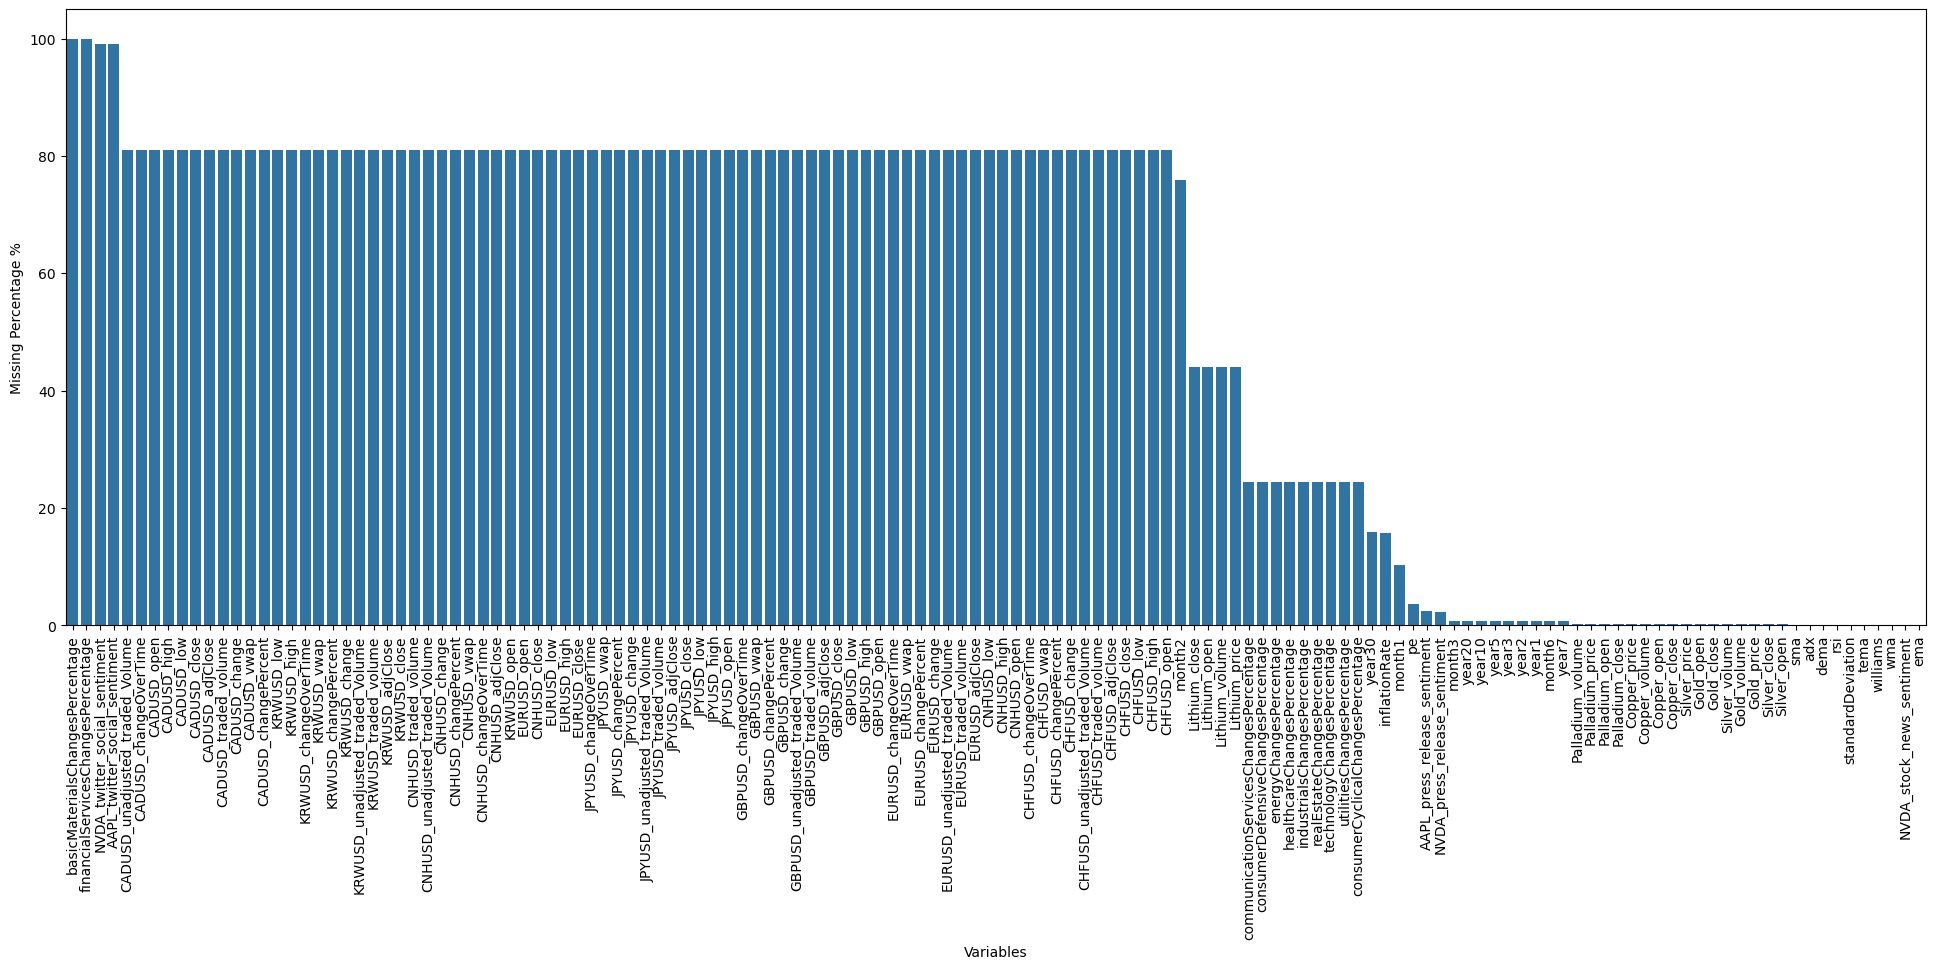

In [104]:
show_percent_missing(aapl_data)

In [105]:
percent_missing(aapl_data)

basicMaterialsChangesPercentage          100.000000000
financialServicesChangesPercentage       100.000000000
NVDA_twitter_social_sentiment             99.100044998
AAPL_twitter_social_sentiment             99.100044998
CADUSD_unadjusted_traded_Volume           80.935953202
CADUSD_changeOverTime                     80.935953202
CADUSD_open                               80.935953202
CADUSD_high                               80.935953202
CADUSD_low                                80.935953202
CADUSD_close                              80.935953202
CADUSD_adjClose                           80.935953202
CADUSD_traded_volume                      80.935953202
CADUSD_change                             80.935953202
CADUSD_vwap                               80.935953202
CADUSD_changePercent                      80.935953202
KRWUSD_low                                80.920953952
KRWUSD_high                               80.920953952
KRWUSD_changeOverTime                     80.920953952
KRWUSD_vwa

In [106]:
nan_percent = 100 * aapl_data.isnull().sum() / len(aapl_data)
nan_percent = nan_percent[nan_percent > 0].sort_values(ascending=False)

cols_to_drop = nan_percent[nan_percent >= 75].index

aapl_data.drop(columns=cols_to_drop, inplace=True)

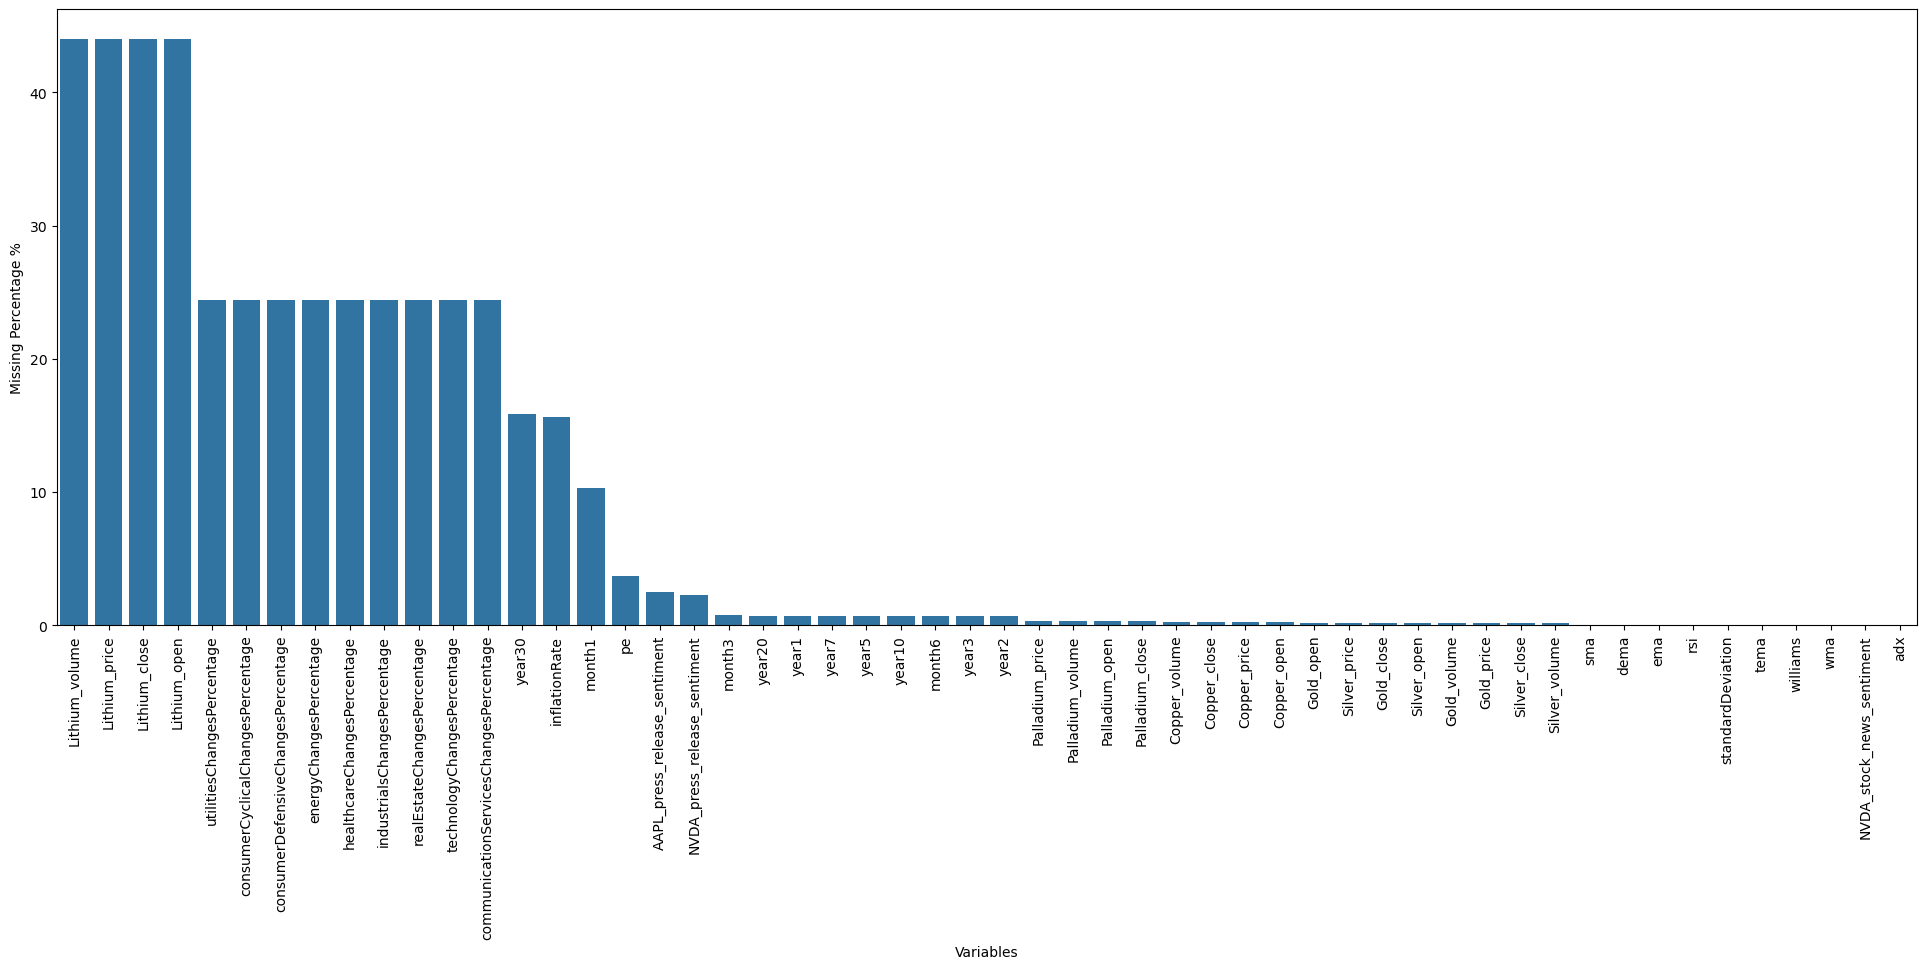

In [107]:
show_percent_missing(aapl_data)

In [108]:
percent_missing(aapl_data)

Lithium_volume                           44.037798110
Lithium_price                            44.037798110
Lithium_close                            44.037798110
Lithium_open                             44.037798110
utilitiesChangesPercentage               24.448777561
consumerCyclicalChangesPercentage        24.448777561
consumerDefensiveChangesPercentage       24.448777561
energyChangesPercentage                  24.448777561
healthcareChangesPercentage              24.448777561
industrialsChangesPercentage             24.448777561
realEstateChangesPercentage              24.448777561
technologyChangesPercentage              24.448777561
communicationServicesChangesPercentage   24.448777561
year30                                   15.839208040
inflationRate                            15.644217789
month1                                   10.319484026
pe                                        3.689815509
AAPL_press_release_sentiment              2.474876256
NVDA_press_release_sentiment

In [109]:
aapl_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6667 entries, 4602 to 11383
Data columns (total 81 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   date                                    6667 non-null   datetime64[ns]
 1   AAPL_close                              6667 non-null   float64       
 2   AAPL_high                               6667 non-null   float64       
 3   AAPL_low                                6667 non-null   float64       
 4   AAPL_open                               6667 non-null   float64       
 5   AAPL_traded_volume                      6667 non-null   int64         
 6   AAPL_adjClose                           6667 non-null   float64       
 7   AAPL_adjLow                             6667 non-null   float64       
 8   AAPL_adjOpen                            6667 non-null   float64       
 9   AAPL_adj_traded_volume                  6667 non-null

In [110]:
# Filling missing values of AAPL_stock_news_sentiment with mode by each year and month
aapl_data['AAPL_stock_news_sentiment']  = aapl_data.groupby(['year', 'month'])['AAPL_stock_news_sentiment'].transform(lambda value: value.fillna(value.mode().iloc[0]))

# Filling missing values of NVDA_stock_news_sentiment with mode by each year and month
aapl_data['NVDA_stock_news_sentiment']  = aapl_data.groupby(['year', 'month'])['NVDA_stock_news_sentiment'].transform(lambda value: value.fillna(value.mode().iloc[0]))

# Filling missing values of AAPL_press_release_statement with mode by each year and month
aapl_data['AAPL_press_release_sentiment']  = aapl_data.groupby(['year', 'month'])['AAPL_press_release_sentiment'].transform(lambda value: value.fillna(value.mode().iloc[0]))

# Filling missing values of NVDA_press_release_sentiment with mode by each year and month
aapl_data['NVDA_press_release_sentiment']  = aapl_data.groupby(['year', 'month'])['NVDA_press_release_sentiment'].transform(lambda value: value.fillna(value.mode().iloc[0]))


# Grouping by year and month or just the year and then filling with the mode or median
def fill_values(feature, dataset):

    dataset[feature] = dataset.groupby(['year', 'month'])[feature].transform(lambda value: value.fillna(value.median()))

    if dataset[feature].isnull().any():
        dataset[feature] = dataset.groupby('year')[feature].transform(lambda value: value.fillna(value.median()))
        

cols_to_fill = ['Gold_volume', 'Gold_close', 'Gold_open', 'Gold_price', 'Copper_close','Copper_price',
                'Copper_volume', 'Copper_open', 'Palladium_price', 'Palladium_volume', 'Palladium_open',
                'Palladium_close', 'Silver_close', 'Silver_open', 'Silver_volume', 'Silver_price',
                'Lithium_volume', 'Lithium_close', 'Lithium_open', 'Lithium_price', 'sma', 'adx', 'dema',
                'ema', 'rsi', 'standardDeviation', 'tema', 'williams', 'wma', 'month3', 'year3', 'year5',
                'year7', 'year10', 'year20', 'year2', 'year1', 'month6', 'realEstateChangesPercentage',
                'utilitiesChangesPercentage', 'communicationServicesChangesPercentage', 'technologyChangesPercentage',
                'industrialsChangesPercentage', 'healthcareChangesPercentage', 'energyChangesPercentage',  
                'consumerDefensiveChangesPercentage', 'consumerCyclicalChangesPercentage', 'year30',
                'inflationRate', 'month1', 'pe']

# Filling columns as defined in function
for col in cols_to_fill:
    fill_values(col, aapl_data)


# Filling inflation rate and interest rates with their respective medians
aapl_data['inflationRate'] = aapl_data['inflationRate'].fillna(aapl_data['inflationRate'].median())
aapl_data['year30'] = aapl_data['year30'].fillna(aapl_data['year30'].median())
aapl_data['month1'] = aapl_data['month1'].fillna(aapl_data['month1'].median())

In [111]:
# cols_to_map = ['AAPL_stock_news_sentiment', 'NVDA_stock_news_sentiment', 'AAPL_press_release_sentiment', 'NVDA_press_release_sentiment'] 


# category_mapping = {'neutral': 0, 'weakly_positive': 0.5, 'strongly_positive': 1, 'weakly_negative': -0.5, 'strongly_negative': 1}

# # mapping using lambda function
# aapl_data[cols_to_map] = aapl_data[cols_to_map].apply(lambda col: col.map(category_mapping))

In [112]:
percent_missing(aapl_data)

Lithium_price    41.907904605
Lithium_volume   41.907904605
Lithium_open     41.907904605
Lithium_close    41.907904605
dtype: float64

In [113]:
# Select only numerical columns
numeric_data = aapl_data.select_dtypes(include=['float64', 'int32', 'int64'])

# Compute correlation of 'Lithium_price' with all other numeric columns
lithium_corr = numeric_data.corr()['Lithium_price'].dropna()

# Compute correlation of 'Lithium_close' with all other numeric columns
lithium_close = numeric_data.corr()['Lithium_close'].dropna()

# Compute correlation of 'Lithium_open' with all other numeric columns
lithium_open = numeric_data.corr()['Lithium_open'].dropna()

# Compute correlation of 'Lithium_open' with all other numeric columns
lithium_vol = numeric_data.corr()['Lithium_volume'].dropna()

# Filter only correlations with absolute value > 0.70
strong_corr = lithium_corr[abs(lithium_corr) > 0.70]

strong_corr_close = lithium_close[abs(lithium_close) > 0.70]

strong_corr_open = lithium_open[abs(lithium_open) > 0.70]

strong_corr_vol = lithium_vol[abs(lithium_vol) > 0.50]


# Print correlation values sorted in descending order
print(strong_corr.sort_values(ascending=False, key=abs), strong_corr_close.sort_values(ascending=False, key=abs), 
      strong_corr_open.sort_values(ascending=False, key=abs), strong_corr_vol.sort_values(ascending=False, key=abs))

Lithium_price   1.000000000
Lithium_close   1.000000000
Lithium_open    0.999542303
Copper_price    0.709388727
Copper_close    0.709388727
Copper_open     0.707830789
Name: Lithium_price, dtype: float64 Lithium_price   1.000000000
Lithium_close   1.000000000
Lithium_open    0.999542303
Copper_price    0.709388727
Copper_close    0.709388727
Copper_open     0.707830789
Name: Lithium_close, dtype: float64 Lithium_open    1.000000000
Lithium_price   0.999542303
Lithium_close   0.999542303
Copper_price    0.709209870
Copper_close    0.709209870
Copper_open     0.708118600
Name: Lithium_open, dtype: float64 Lithium_volume       1.000000000
Lithium_open         0.697514505
Lithium_close        0.697157527
Lithium_price        0.697157527
Palladium_open       0.633056061
Palladium_price      0.631914921
Palladium_close      0.631914921
year                 0.568957358
wma                  0.564052953
sma                  0.564052953
dema                 0.564052953
ema                  0.564

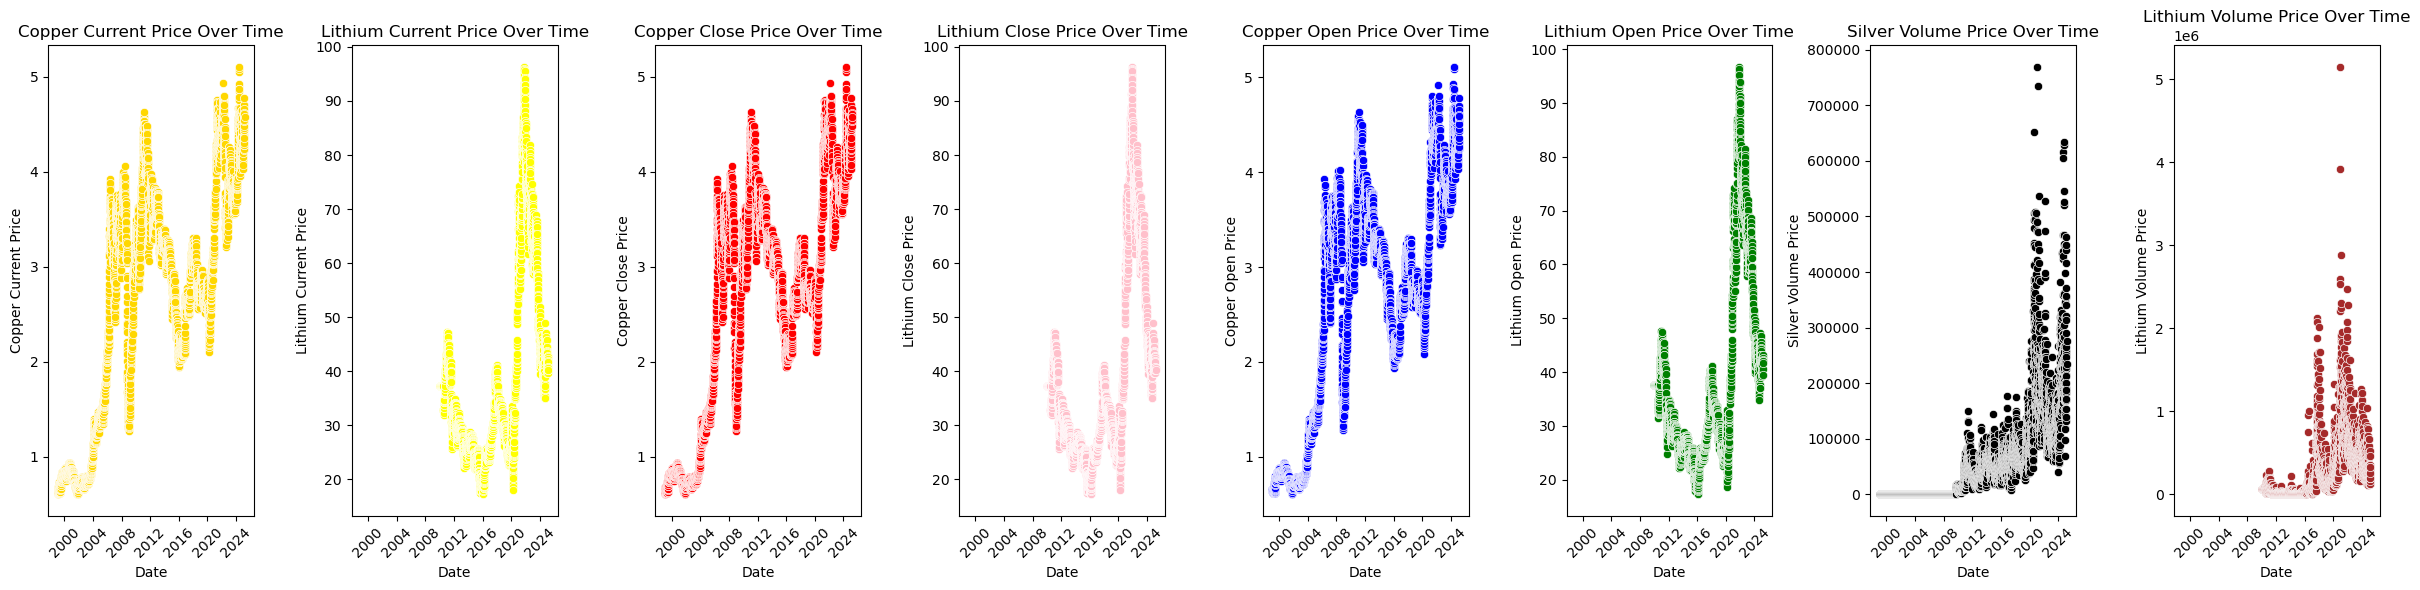

In [114]:
# Create figure and axes for two subplots side by side
fig, axes = plt.subplots(1, 8, figsize=(24, 6), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# First scatter plot: Gold price
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Copper_price'], ax=axes[0], color='gold')
axes[0].set_title('Copper Current Price Over Time')
axes[0].set_ylabel('Copper Current Price')

# Second scatter plot: Lithium price
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_price'], ax=axes[1], color='yellow')
axes[1].set_title('Lithium Current Price Over Time')
axes[1].set_ylabel('Lithium Current Price')

# third scatter plot: Copper_close
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Copper_close'], ax=axes[2], color='red')
axes[2].set_title('Copper Close Price Over Time')
axes[2].set_ylabel('Copper Close Price')

# fourth scatter plot: Lithium close
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_close'], ax=axes[3], color='pink')
axes[3].set_title('Lithium Close Price Over Time')
axes[3].set_ylabel('Lithium Close Price')

# fifth scatter plot: Copper_open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Copper_open'], ax=axes[4], color='blue')
axes[4].set_title('Copper Open Price Over Time')
axes[4].set_ylabel('Copper Open Price')

# Sixth scatter plot: Lithium open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_open'], ax=axes[5], color='green')
axes[5].set_title('Lithium Open Price Over Time')
axes[5].set_ylabel('Lithium Open Price')

# Seventh scatter plot: Copper_open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Silver_volume'], ax=axes[6], color='black')
axes[6].set_title('Silver Volume Price Over Time')
axes[6].set_ylabel('Silver Volume Price')

# Eighth scatter plot: Lithium open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_volume'], ax=axes[7], color='brown')
axes[7].set_title('Lithium Volume Price Over Time')
axes[7].set_ylabel('Lithium Volume Price')

# Rotate x-axis labels for better readability
for ax in axes:
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()


In [115]:

def linear_reg_filling(col_to_fill, col_to_use, dataset):
    """ 
    col_to_fill: This is essentially the column to fill missing values on 
    col_to_use: This is the column that is trained on the linear model to create predictions on col_to_fill
    dataset: The dataset to use 
    """

    # The correlation between copper and lithium features are high (0.70). Hence, I would use a linear regression model to predict the missing values of lithium and fill them up
    # A similar correlation is shown for the other features plotted above
    from sklearn.linear_model import LinearRegression


    # Add a small constant to avoid issues with log(0)
    epsilon = 1e-5

    dataset[f"{col}_log"] = np.log(dataset[col_to_fill] + epsilon)

    # Extract rows with missing column values
    missing_data = dataset[dataset[col_to_fill].isna()]

    # Use non-missing values for fitting the regression model
    train_data = dataset.dropna(subset=[col_to_fill])

    # Reshape data to 2D (needed for sklearn)
    X_train = train_data[[col_to_use]]  # Copper as independent variable
    y_train = train_data[f"{col}_log"]  # Lithium as dependent variable

    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict Lithium values for the missing data
    X_missing = missing_data[[col_to_use]]
    predicted_col_log = model.predict(X_missing)

    # Apply inverse log transformation to predict original Lithium values
    predictions = np.exp(predicted_col_log) - epsilon

    # Fill missing Lithium values with the predicted values
    dataset.loc[dataset[col_to_fill].isna(), col_to_fill] = predictions


linear_reg_filling('Lithium_price', 'Copper_price', aapl_data)
linear_reg_filling('Lithium_close', 'Copper_close', aapl_data)
linear_reg_filling('Lithium_open', 'Copper_open', aapl_data)
linear_reg_filling('Lithium_volume', 'Silver_volume', aapl_data)

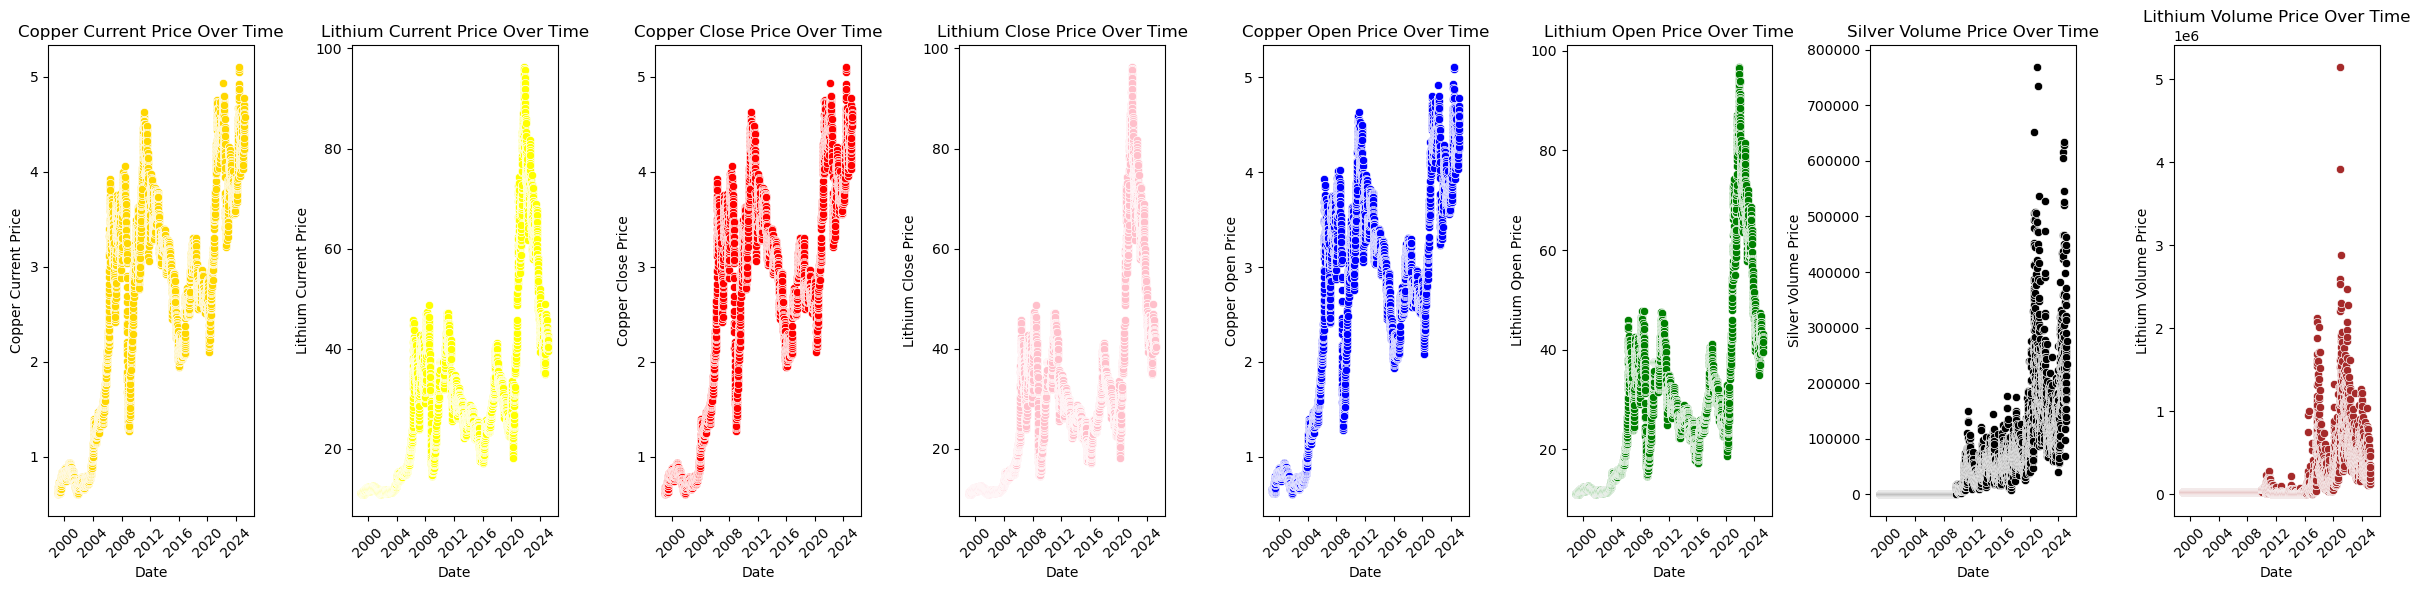

In [116]:
# Create figure and axes for two subplots side by side
fig, axes = plt.subplots(1, 8, figsize=(24, 6), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# First scatter plot: Gold price
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Copper_price'], ax=axes[0], color='gold')
axes[0].set_title('Copper Current Price Over Time')
axes[0].set_ylabel('Copper Current Price')

# Second scatter plot: Lithium price
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_price'], ax=axes[1], color='yellow')
axes[1].set_title('Lithium Current Price Over Time')
axes[1].set_ylabel('Lithium Current Price')

# third scatter plot: Copper_close
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Copper_close'], ax=axes[2], color='red')
axes[2].set_title('Copper Close Price Over Time')
axes[2].set_ylabel('Copper Close Price')

# fourth scatter plot: Lithium close
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_close'], ax=axes[3], color='pink')
axes[3].set_title('Lithium Close Price Over Time')
axes[3].set_ylabel('Lithium Close Price')

# fifth scatter plot: Copper_open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Copper_open'], ax=axes[4], color='blue')
axes[4].set_title('Copper Open Price Over Time')
axes[4].set_ylabel('Copper Open Price')

# Sixth scatter plot: Lithium open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_open'], ax=axes[5], color='green')
axes[5].set_title('Lithium Open Price Over Time')
axes[5].set_ylabel('Lithium Open Price')

# Seventh scatter plot: Copper_open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Silver_volume'], ax=axes[6], color='black')
axes[6].set_title('Silver Volume Price Over Time')
axes[6].set_ylabel('Silver Volume Price')

# Eighth scatter plot: Lithium open
sns.scatterplot(x=aapl_data['date'], y=aapl_data['Lithium_volume'], ax=axes[7], color='brown')
axes[7].set_title('Lithium Volume Price Over Time')
axes[7].set_ylabel('Lithium Volume Price')

# Rotate x-axis labels for better readability
for ax in axes:
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()

In [117]:
aapl_data.drop(columns='pe_log', inplace=True)

percent_missing(aapl_data)

Series([], dtype: float64)

In [118]:
aapl_data.isnull().sum()

date                                      0
AAPL_close                                0
AAPL_high                                 0
AAPL_low                                  0
AAPL_open                                 0
AAPL_traded_volume                        0
AAPL_adjClose                             0
AAPL_adjLow                               0
AAPL_adjOpen                              0
AAPL_adj_traded_volume                    0
AAPL_divCash                              0
AAPL_splitFactor                          0
pe                                        0
communicationServicesChangesPercentage    0
consumerCyclicalChangesPercentage         0
consumerDefensiveChangesPercentage        0
energyChangesPercentage                   0
healthcareChangesPercentage               0
industrialsChangesPercentage              0
realEstateChangesPercentage               0
technologyChangesPercentage               0
utilitiesChangesPercentage                0
month1                          

In [119]:
# creating a separate copy for other models that do not require creating lagged features
separate_aapl_data = aapl_data.copy()

In [120]:
aapl_data.sample(8).sort_values('date')

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,month,year,season
4825,1999-11-26,95.060000000,95.500000000,94.120000000,94.750000000,1179200,0.715108835,0.708037488,0.712776795,132070532,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,5.300000000,5.540000000,5.680000000,5.990000000,6.030000000,6.060000000,6.250000000,6.120000000,6.570000000,6.240000000,2.190000000,400.825000000,241.000000000,397.500000000,400.825000000,0.790250000,7397.500000000,0.796250000,0.790250000,11.843441859,29792.528908717,11.903784753,11.843441859,5.210000000,0.000000000,5.210000000,5.210000000,297.120000000,0.000000000,298.750000000,297.120000000,0.848770000,100.000000000,0.848770000,0.848770000,100.000000000,0.000000000,0.848770000,-31.840390879,0.848770000,weakly_positive,neutral,38.250000000,38.500000000,37.000000000,38.130000000,149500.000000000,0.073088047,0.070699549,0.072858751,71759964.000000000,0.000000000,1.000000000,neutral,neutral,11,1999,Fall
5876,2003-12-24,20.410000000,20.590000000,19.650000000,19.720000000,3169200,0.307077032,0.295642512,0.296695692,177475377,0.000000000,1.000000000,45.975349280,0.454130000,-4.163410000,-0.382300000,1.639360000,0.000050000,-0.157160000,0.246930000,-0.000260000,-0.005790000,0.870000000,0.900000000,1.000000000,1.280000000,1.830000000,2.360000000,3.200000000,3.720000000,4.200000000,5.020000000,3.730000000,2.240000000,207.150000000,130.000000000,208.500000000,207.150000000,1.023000000,2553.000000000,1.020500000,1.023000000,13.095844133,29792.528908717,13.112134703,13.095844133,5.760000000,0.000000000,5.720000000,5.760000000,412.050000000,0.000000000,410.550000000,412.050000000,0.364460000,100.000000000,0.364460000,0.364460000,100.000000000,0.000000000,0.364460000,-19.178082192,0.364460000,neutral,neutral,21.800000000,22.020000000,21.740000000,22.020000000,1757100.000000000,0.166621640,0.166163048,0.168303142,210851894.000000000,0.000000000,1.000000000,neutral,weakly_positive,12,2003,Winter
6067,2004-09-16,36.350000000,36.760000000,35.080000000,35.200000000,8962800,0.546901034,0.527793350,0.529598801,501917301,0.000000000,1.000000000,3.349432391,1.174920000,0.007470000,-0.347610000,0.096160000,2.025610000,-0.683750000,1.539670000,6.922120000,0.818820000,1.550000000,1.670000000,1.870000000,2.060000000,2.440000000,2.750000000,3.290000000,3.690000000,4.080000000,4.860000000,3.730000000,2.270000000,211.250000000,357.000000000,212.200000000,211.250000000,1.301500000,12840.000000000,1.270500000,1.301500000,14.769647140,29792.528908717,14.604380472,14.769647140,6.285000000,0.000000000,6.220000000,6.285000000,404.520000000,0.000000000,405.150000000,404.520000000,0.649110000,100.000000000,0.649110000,0.649110000,100.000000000,0.000000000,0.649110000,-24.400000000,0.649110000,strongly_positive,neutral,14.110000000,14.250000000,13.780000000,13.830000000,6750200.0000000

In [121]:
def created_lagged_features_daily(data, target_col, external_features, max_lag=30):
    df = data.copy()

    # lag target feature (stock price) from 1 to 7 days
    # for lag in range(1, 8):
    for lag in range(1, max_lag + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)

    # Selectively lagging external features with specific lags
    for feature in external_features:
        if feature == 'inflationRate':
            # attempting to capture long-term dependency with max lags
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'Gold_price':
            # lagging short-term dependencies
            # for lag in range(1, 8):
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
        
        elif feature == 'Silver_price':
            # lagging short-term dependencies
            # for lag in range(1, 8):
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'AAPL_stock_news_sentiment':
            # lagging very short-term dependencies for news sentiments as news trends change often
            # for lag in range(1, 6):
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

        elif feature == 'NVDA_stock_news_sentiment':
            # lagging short-term dependencies for press releases
            # for lag in range(1, 8):
            for lag in range(1, max_lag + 1):
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    
    df.dropna(inplace=True) # dropping all NaN values after shifting
    
    return df

In [122]:
external_features = [ 'Silver_price', 'inflationRate', 'NVDA_stock_news_sentiment', 'Gold_price', 'AAPL_stock_news_sentiment']

aapl_data = created_lagged_features_daily(aapl_data, 'AAPL_close', external_features=external_features)

aapl_data['day'] = aapl_data['date'].dt.day

aapl_data.head()

C:\Users\ekf98\AppData\Local\Temp\ipykernel_12004\454181893.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
C:\Users\ekf98\AppData\Local\Temp\ipykernel_12004\454181893.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
C:\Users\ekf98\AppData\Local\Temp\ipykernel_12004\454181893.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,month,year,season,AAPL_close_lag_1,AAPL_close_lag_2,AAPL_close_lag_3,AAPL_close_lag_4,AAPL_close_lag_5,AAPL_close_lag_6,AAPL_close_lag_7,AAPL_close_lag_8,AAPL_close_lag_9,AAPL_close_lag_10,AAPL_close_lag_11,AAPL_close_lag_12,AAPL_close_lag_13,AAPL_close_lag_14,AAPL_close_lag_15,AAPL_close_lag_16,AAPL_close_lag_17,AAPL_close_lag_18,AAPL_close_lag_19,AAPL_close_lag_20,AAPL_close_lag_21,AAPL_close_lag_22,AAPL_close_lag_23,AAPL_close_lag_24,AAPL_close_lag_25,AAPL_close_lag_26,AAPL_close_lag_27,AAPL_close_lag_28,AAPL_close_lag_29,AAPL_close_lag_30,Silver_price_lag_1,Silver_price_lag_2,Silver_price_lag_3,Silver_price_lag_4,Silver_price_lag_5,Silver_price_lag_6,Silver_price_lag_7,Silver_price_lag_8,Silver_price_lag_9,Silver_price_lag_10,Silver_price_lag_11,Silver_price_lag_12,Silver_price_lag_13,Silver_price_lag_14,Silver_price_lag_15,Silver_price_lag_16,Silver_price_lag_17,Silver_price_lag_18,Silver_price_lag_19,Silver_price_lag_20,Silver_price_lag_21,Silver_price_lag_22,Silver_price_lag_23,Silver_price_lag_24,Silver_price_lag_25,Silver_price_lag_26,Silver_price_lag_27,Silver_price_lag_28,Silver_price_lag_29,Silver_price_lag_30,inflationRate_lag_1,inflationRate_lag_2,inflationRate_lag_3,inflationRate_lag_4,inflationRate_lag_5,inflationRate_lag_6,inflationRate_lag_7,inflationRate_lag_8,inflationRate_lag_9,inflationRate_lag_10,inflationRate_lag_11,inflationRate_lag_12,inflationRate_lag_13,inflationRate_lag_14,inflationRate_lag_15,inflationRate_lag_16,inflationRate_lag_17,inflationRate_lag_18,inflationRate_lag_19,inflationRate_lag_20,inflationRate_lag_21,inflationRate_lag_22,inflationRate_lag_23,inflationRate_lag_24,inflationRate_lag_25,inflationRate_lag_26,inflationRate_lag_27,inflationRate_lag_28,inflationRate_lag_29,inflationRate_lag_30,NVDA_stock_news_sentiment_lag_1,NVDA_stock_news_sentiment_lag_2,NVDA_stock_news_sentiment_lag_3,NVDA_stock_news_sentiment_lag_4,NVDA_stock_news_sentiment_lag_5,NVDA_stock_news_sentiment_lag_6,NVDA_stock_news_sentiment_lag_7,NVDA_stock_news_sentiment_lag_8,NVDA_stock_news_sentiment_lag_9,NVDA_stock_news_sentiment_lag_10,NVDA_stock_news_sentiment_lag_11,NVDA_stock_news_sentiment_lag_12,NVDA_stock_news_sentiment_lag_13,NVDA_stock_news_sentiment_lag_14,NVDA_stock_news_sentiment_lag_15,NVDA_stock_news_sentiment_lag_16,NVDA_stock_news_sentiment_lag_17,NVDA_stock_news_sentiment_lag_18,NVDA_stock_news_sentiment_lag_19,NVDA_stock_news_sentiment_lag_20,NVDA_stock_news_sentiment_lag_21,NVDA_stock_news_sentiment_lag_22,NVDA_stock_news_sentiment_lag_23,NVDA_stock_news_sentiment_lag_24,NVDA_stock_news_sentiment_lag_25,NVDA_stock_news_sentiment_lag_26,NVDA_stock_news_sentiment_lag_27,NVDA_stock_news_sentiment_lag_28,NVDA_stock_news_sentiment_lag_29,NVDA_stock_news_sentiment_lag_30,Gold_price_lag_1,Gold_price_lag_2,Gold_price_lag_3,Gold_price_lag_4,Gold_price_lag_5,Gold_price_lag_6,Gold_price_lag_7,Gold_price_lag_8,Gold_price_lag_9,G

In [123]:
aapl_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6637 entries, 4632 to 11383
Columns: 262 entries, date to day
dtypes: datetime64[ns](1), float64(191), int32(3), int64(2), object(65)
memory usage: 13.2+ MB


In [124]:
# Obtainig Dummies
aapl_data = pd.get_dummies(aapl_data, drop_first=True)

# grouping categorical & numerical features for further transformations

# cat_cols = list(aapl_data.select_dtypes(include='object').columns)

num_cols = list(aapl_data.select_dtypes(include=['float64', 'int64', 'int32']).columns)

num_cols.remove('AAPL_close')

print(num_cols)

print(len(num_cols), len(aapl_data.columns))

['AAPL_high', 'AAPL_low', 'AAPL_open', 'AAPL_traded_volume', 'AAPL_adjClose', 'AAPL_adjLow', 'AAPL_adjOpen', 'AAPL_adj_traded_volume', 'AAPL_divCash', 'AAPL_splitFactor', 'pe', 'communicationServicesChangesPercentage', 'consumerCyclicalChangesPercentage', 'consumerDefensiveChangesPercentage', 'energyChangesPercentage', 'healthcareChangesPercentage', 'industrialsChangesPercentage', 'realEstateChangesPercentage', 'technologyChangesPercentage', 'utilitiesChangesPercentage', 'month1', 'month3', 'month6', 'year1', 'year2', 'year3', 'year5', 'year7', 'year10', 'year20', 'year30', 'inflationRate', 'Palladium_price', 'Palladium_volume', 'Palladium_open', 'Palladium_close', 'Copper_price', 'Copper_volume', 'Copper_open', 'Copper_close', 'Lithium_price', 'Lithium_volume', 'Lithium_open', 'Lithium_close', 'Silver_price', 'Silver_volume', 'Silver_open', 'Silver_close', 'Gold_price', 'Gold_volume', 'Gold_open', 'Gold_close', 'sma', 'adx', 'dema', 'ema', 'rsi', 'standardDeviation', 'tema', 'williams

In [125]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))


aapl_data[num_cols] = scaler.fit_transform(aapl_data[num_cols])

# # Standardizing numerical features
# scaler = StandardScaler()
# aapl_data[num_cols] = scaler.fit_transform(aapl_data[num_cols])

aapl_data.head()

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,month,year,AAPL_close_lag_1,AAPL_close_lag_2,AAPL_close_lag_3,AAPL_close_lag_4,AAPL_close_lag_5,AAPL_close_lag_6,AAPL_close_lag_7,AAPL_close_lag_8,AAPL_close_lag_9,AAPL_close_lag_10,AAPL_close_lag_11,AAPL_close_lag_12,AAPL_close_lag_13,AAPL_close_lag_14,AAPL_close_lag_15,AAPL_close_lag_16,AAPL_close_lag_17,AAPL_close_lag_18,AAPL_close_lag_19,AAPL_close_lag_20,AAPL_close_lag_21,AAPL_close_lag_22,AAPL_close_lag_23,AAPL_close_lag_24,AAPL_close_lag_25,AAPL_close_lag_26,AAPL_close_lag_27,AAPL_close_lag_28,AAPL_close_lag_29,AAPL_close_lag_30,Silver_price_lag_1,Silver_price_lag_2,Silver_price_lag_3,Silver_price_lag_4,Silver_price_lag_5,Silver_price_lag_6,Silver_price_lag_7,Silver_price_lag_8,Silver_price_lag_9,Silver_price_lag_10,Silver_price_lag_11,Silver_price_lag_12,Silver_price_lag_13,Silver_price_lag_14,Silver_price_lag_15,Silver_price_lag_16,Silver_price_lag_17,Silver_price_lag_18,Silver_price_lag_19,Silver_price_lag_20,Silver_price_lag_21,Silver_price_lag_22,Silver_price_lag_23,Silver_price_lag_24,Silver_price_lag_25,Silver_price_lag_26,Silver_price_lag_27,Silver_price_lag_28,Silver_price_lag_29,Silver_price_lag_30,inflationRate_lag_1,inflationRate_lag_2,inflationRate_lag_3,inflationRate_lag_4,inflationRate_lag_5,inflationRate_lag_6,inflationRate_lag_7,inflationRate_lag_8,inflationRate_lag_9,inflationRate_lag_10,inflationRate_lag_11,inflationRate_lag_12,inflationRate_lag_13,inflationRate_lag_14,inflationRate_lag_15,inflationRate_lag_16,inflationRate_lag_17,inflationRate_lag_18,inflationRate_lag_19,inflationRate_lag_20,inflationRate_lag_21,inflationRate_lag_22,inflationRate_lag_23,inflationRate_lag_24,inflationRate_lag_25,inflationRate_lag_26,inflationRate_lag_27,inflationRate_lag_28,inflationRate_lag_29,inflationRate_lag_30,Gold_price_lag_1,Gold_price_lag_2,Gold_price_lag_3,Gold_price_lag_4,Gold_price_lag_5,Gold_price_lag_6,Gold_price_lag_7,Gold_price_lag_8,Gold_price_lag_9,Gold_price_lag_10,Gold_price_lag_11,Gold_price_lag_12,Gold_price_lag_13,Gold_price_lag_14,Gold_price_lag_15,Gold_price_lag_16,Gold_price_lag_17,Gold_price_lag_18,Gold_price_lag_19,Gold_price_lag_20,Gold_price_lag_21,Gold_price_lag_22,Gold_price_lag_23,Gold_price_lag_24,Gold_price_lag_25,Gold_price_lag_26,Gold_price_lag_27,Gold_price_lag_28,Gold_price_lag_29,Gold_price_lag_30,day,AAPL_stock_news_sentiment_strongly_negative,AAPL_stock_news_sentiment_strongly_positive,AAPL_stock_news_sentiment_weakly_negative,AAPL_stock_news_sentiment_weakly_positive,AAPL_press_release_sentiment_strongly_negative,AAPL_press_release_sentiment_strongly_positive,AAPL_press_release_sentiment_weakly_negative,AAPL_press_release_sentiment_weakly_positive,NVDA_stock_news_sentiment_strongly_negative,NVDA_stock_news_sentiment_strongly_positive,NVDA_stock_news_sentiment_weakly_negative,NVDA_stock_news_sentiment_weakly_positive,NVDA_press_release_sentiment_strongly_negative,NVDA_press_release_sentiment_strongly_positive,NVDA_press_release_sentiment_weakly_negative,NVDA_press_release_sentiment_weakly_positive,seaso

In [126]:
aapl_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6637 entries, 4632 to 11383
Columns: 456 entries, date to AAPL_stock_news_sentiment_lag_30_weakly_positive
dtypes: bool(259), datetime64[ns](1), float64(196)
memory usage: 11.7 MB


# Lasso (Baseline) Model For Apple

In [127]:
# Step 2: Split the data based on a date threshold ( using the 80th percentile of dates as the split point)
split_date = aapl_data['date'].quantile(0.8) 
train_data = aapl_data[aapl_data['date'] <= split_date]
test_data = aapl_data[aapl_data['date'] > split_date]


# creating response and predictor features
X = train_data.drop(columns=["AAPL_close"]) 
y = train_data["AAPL_close"]

x_test = test_data.drop(columns=['AAPL_close'])
y_test = test_data['AAPL_close']

In [128]:
# Creating folds for cross-validation to determine optimum Lasso
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

# Creating unix timestamps of date column as lasso requires that to process the 'date' column
X["date"] = X["date"].astype('int64') // 10**9  # Converts to Unix timestamp (seconds)

# Setting up cross-validated Lasso Model
lassoCV = LassoCV(alphas=np.logspace(-5, 2, 150), # Creating range of alphas from 0.00001 to 10000 for 180 evenly spaced samples  
                  cv=kfold,
                  random_state=1,
                  max_iter= 50000,
                  n_jobs=-1)

# Fitting a lasso model on training X and Y values
tuned_lasso = lassoCV.fit(X,y)

# Displaying the optimum Lasso the minimizes the Root mean squared error
print(f"Optimum Lasso: {tuned_lasso.alpha_}")

# Obtaining the Training RMSE obtained from the optimum lasso
validation_mse = np.min(tuned_lasso.mse_path_.mean(1))
print(f'Validation RMSE: {np.sqrt(validation_mse)}')

Optimum Lasso: 0.01260872407680681
Validation RMSE: 1.3189713766233133


In [129]:
final_lasso = Lasso(alpha=tuned_lasso.alpha_, max_iter=25000)

final_lasso.fit(X, y)

x_test["date"] = x_test["date"].astype('int64') // 10**9  # Converts to Unix timestamp (seconds)

y_pred = final_lasso.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {rmse}")

Test RMSE: 1.0928618280012683


c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.092e+04, tolerance: 1.338e+04
  model = cd_fast.enet_coordinate_descent(


Validation RMSE: 1.9213695340801884
Validation RMSE: 3.0805650788327914
Validation RMSE: 4.665408251557364


c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e+04, tolerance: 8.890e+03
  model = cd_fast.enet_coordinate_descent(


Validation RMSE: 1.395629024552142


c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.301e+04, tolerance: 1.325e+04
  model = cd_fast.enet_coordinate_descent(


Validation RMSE: 0.6798368811936567


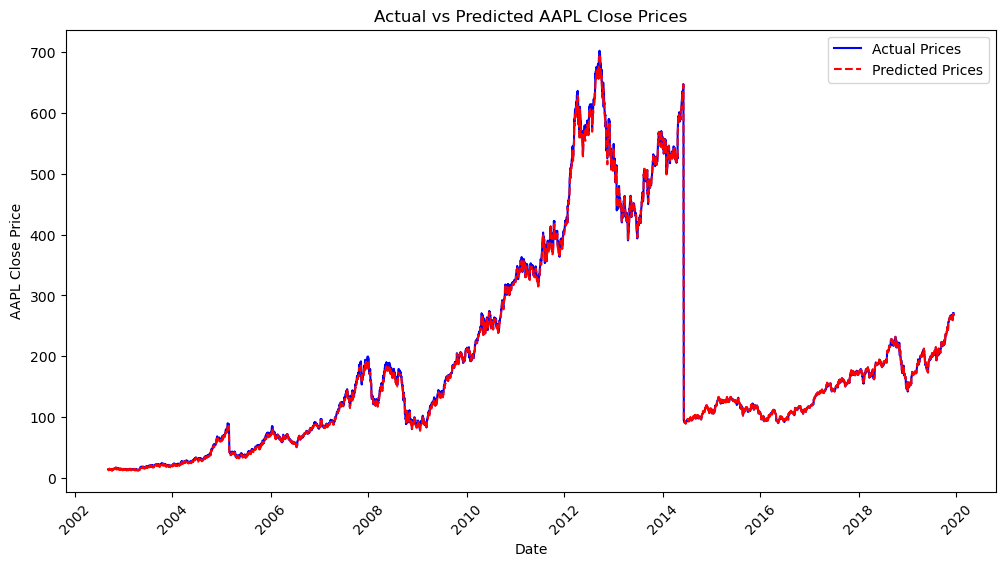

In [130]:
# timeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=K)

# Store actual and predicted values
all_dates = []
all_actuals = []
all_preds = []


final_lasso = Lasso(alpha=tuned_lasso.alpha_, max_iter=25000)

X['date'] = train_data['date']

X["date"] = X["date"].astype('int64') // 10**9  # Converts to Unix timestamp (seconds)

# cross-validation loop
for train, valid in tscv.split(X):
    x_train, x_valid = X.iloc[train], X.iloc[valid]
    y_train, y_valid = y.iloc[train], y.iloc[valid]

    
    final_lasso.fit(x_train, y_train)
    y_pred = final_lasso.predict(x_valid)

    # Collect results
    all_dates.extend(x_valid['date'])
    all_actuals.extend(y_valid)
    all_preds.extend(y_pred)

    # Calculating performance
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(f'Validation RMSE: {rmse}')

# Create DataFrame for plotting
results_df = pd.DataFrame({'Date': all_dates, 'Actual': all_actuals, 'Predicted': all_preds})

results_df['Date'] = pd.to_datetime(results_df['Date'], unit='s')

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Date', y='Actual', label='Actual Prices', color='blue')
sns.lineplot(data=results_df, x='Date', y='Predicted', label='Predicted Prices', color='red', linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Actual vs Predicted AAPL Close Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.092e+04, tolerance: 1.338e+04
  model = cd_fast.enet_coordinate_descent(


Test RMSE: 1.0928618280012683


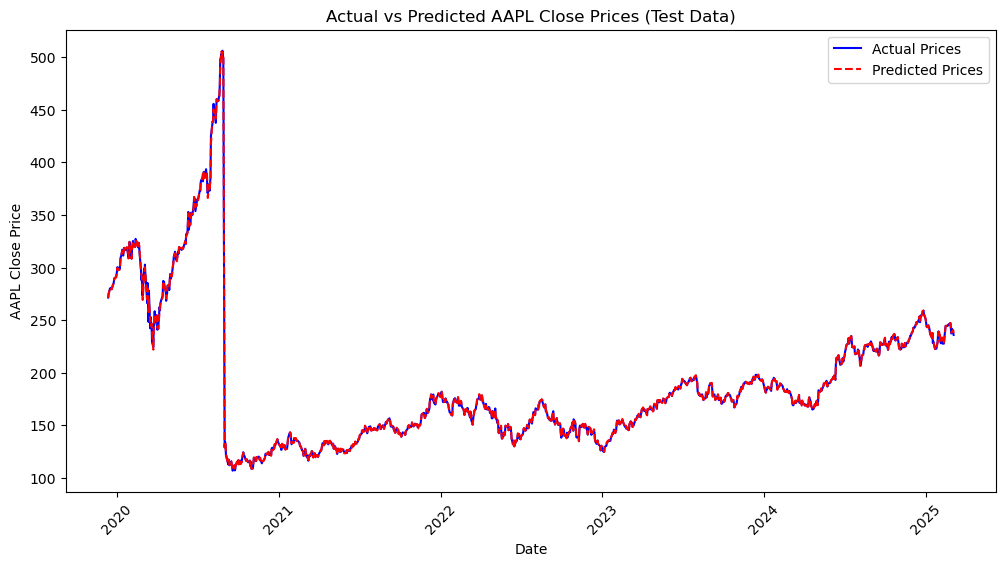

c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\ekf98\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with featu

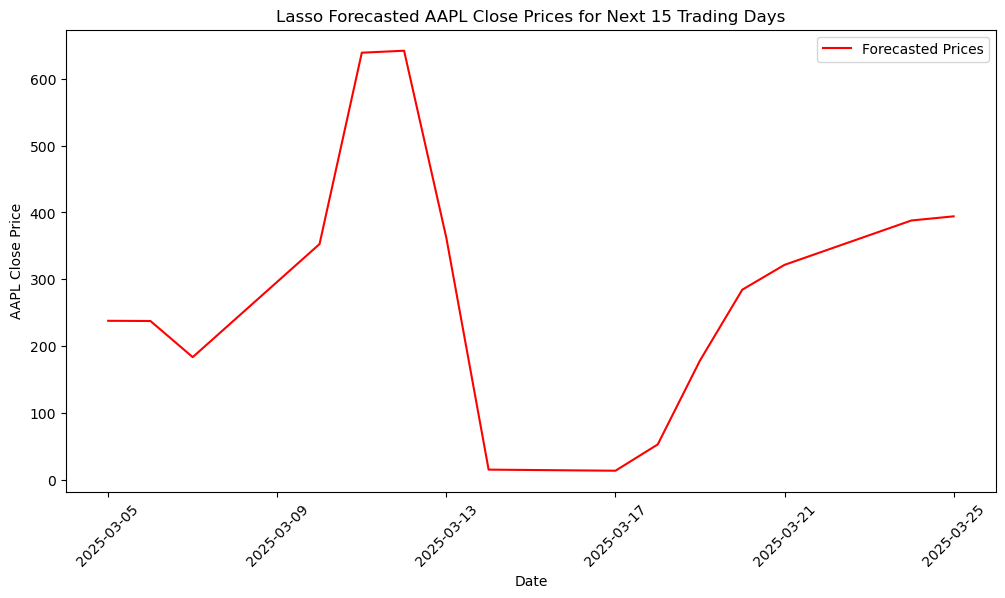

In [ ]:
x_test = test_data.drop(columns=['AAPL_close'])
x_test["date"] = x_test["date"].astype('int64') // 10**9  # Converts to Unix timestamp (seconds)

y_test = test_data['AAPL_close']


final_lasso.fit(X, y)
y_pred = final_lasso.predict(x_test)


# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse}')

x_test['date'] = pd.to_datetime(x_test['date'], unit='s')

# Create DataFrame for test data results
test_results_df = pd.DataFrame({'Date': x_test['date'], 'Actual': y_test, 'Predicted': y_pred})

# Plot actual vs. predicted prices for test data
plt.figure(figsize=(12, 6))
sns.lineplot(data=test_results_df, x='Date', y='Actual', label='Actual Prices', color='blue')
sns.lineplot(data=test_results_df, x='Date', y='Predicted', label='Predicted Prices', color='red', linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Actual vs Predicted AAPL Close Prices (Test Data)")
plt.legend()
plt.xticks(rotation=45)
plt.show()



#################### ----------------------------------------------------------- ##############
# Generating Forecast for the Next 3 Weeks (21 days)

# Convert 'date' to datetime before finding the max date
x_test['date'] = pd.to_datetime(x_test['date'])

# Find the last date in the dataset
last_date = x_test['date'].max()

# Create a new date range for the next 21 days
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=21, freq='B')


# Initialize the forecast list
forecast_lasso = []

# Use the entire x_test data for the first prediction
last_known_data = x_test.values

for _ in range(15):  # Forecasting for the next 15 trading days
    # Convert Timestamp to numeric (Unix timestamp) if necessary
    if isinstance(last_known_data[0, 0], pd.Timestamp):
        last_known_data[:, 0] = np.array([t.timestamp() for t in last_known_data[:, 0]])

     # Ensure data is float type
    last_known_data = last_known_data.astype(float)

    # Predict the next value using the entire dataset
    pred = final_lasso.predict(last_known_data)[-1]  # Use the last prediction from the model's output
    pred = max(pred, 0)  # Ensure the prediction is not negative
    forecast_lasso.append(pred)
    
    # Append the new prediction to the last_known_data
    new_row = np.roll(last_known_data[-1], -1)  # Shift the last row
    new_row[-1] = pred  # Add the new prediction to the last position
    last_known_data = np.vstack([last_known_data, new_row])  # Append the new row to the dataset

# Create a DataFrame for future dates
future_df = pd.DataFrame({'date': future_dates[:15],  # Assuming future_dates has at least 15 dates
                          'forecasted_prices': forecast_lasso})


# Plot forecasted prices
plt.figure(figsize=(12, 6))
sns.lineplot(data=future_df, x='date', y='forecasted_prices', label='Forecasted Prices', color='red')

plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Lasso Forecasted AAPL Close Prices for Next 15 Trading Days")
plt.legend()
plt.xticks(rotation=45)
plt.show()

          date  forecasted_prices    AAPL_close
0  2025-03-05      237.818948691 235.740000000
1  2025-03-06      237.507550255 235.330000000
2  2025-03-07      183.457139711 239.070000000
3  2025-03-10      352.615290147 227.480000000
4  2025-03-11      638.941985039 220.840000000
5  2025-03-12      641.899318509 216.980000000
6  2025-03-13      361.820533446 209.680000000
7  2025-03-14       15.141461705 213.490000000
8  2025-03-17       13.499223991 214.000000000
9  2025-03-18       52.816461477 212.690000000
10 2025-03-19      178.409358966 215.240000000
11 2025-03-20      284.335331790 214.100000000
12 2025-03-21      321.519452768 218.270000000
13 2025-03-24      387.893309186 220.730000000
14 2025-03-25      394.107721318 223.750000000 

Pearson Correlation between forecasted prices and actual prices: 0.06068139835242481  with a p-value of: 0.8299030408275637 
 Spearman Correlation between forecasted prices and actual prices: 0.25  with a p-value of: 0.36884629178393047 
 Foreca

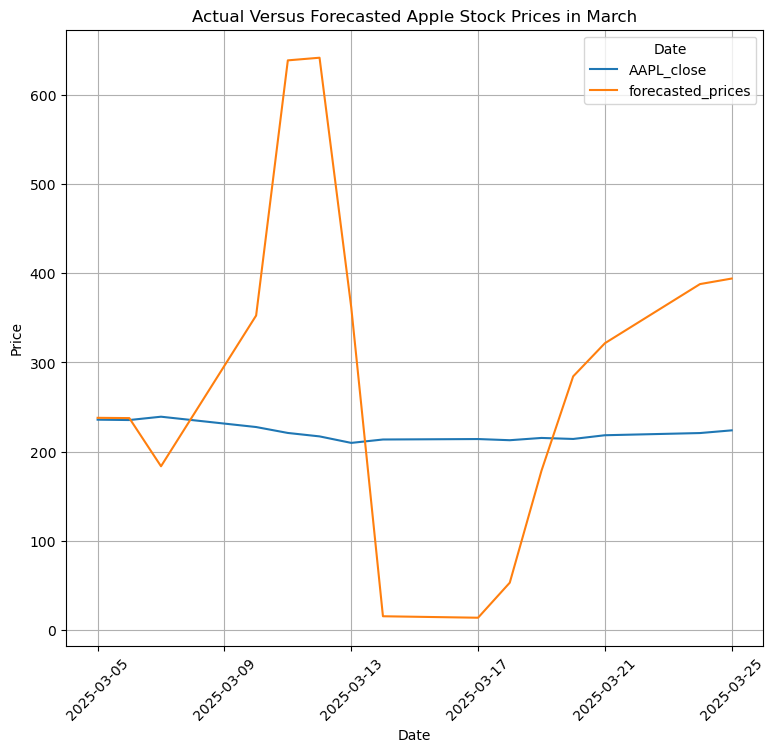

In [132]:
apple_march_prices = pd.read_csv("march_prices/AAPL_march_prices.csv")


apple_lasso = pd.concat([future_df, apple_march_prices['AAPL_close']], axis=1)

print(f" {apple_lasso} \n")

# Assuming you have two columns: 'forecasted_prices' and 'AAPL_close'
correlation, p_value = pearsonr(apple_lasso['forecasted_prices'], apple_lasso['AAPL_close'])

# Calculate Spearman's correlation
spearman_corr, p_value_spear = spearmanr(apple_lasso['forecasted_prices'], apple_lasso['AAPL_close'])


# Calculate Pearson correlation
correlation = apple_lasso[['forecasted_prices', 'AAPL_close']].corr().iloc[0, 1]


rmse = np.sqrt(np.mean((apple_lasso['AAPL_close'] - apple_lasso['forecasted_prices'])**2)) # for our given stock price ranges, rmse between 5-10 is good but the lower the better

mae = np.mean(np.abs((apple_lasso['AAPL_close'] - apple_lasso['forecasted_prices']))) # similarly for mae, the lower the better

mape = np.mean(np.abs((apple_lasso['AAPL_close'] - apple_lasso['forecasted_prices']) / apple_lasso['AAPL_close'])) * 100 # aim for mape below 10% if possible


# Prioritising correlation overall is key. Hopefully the ARIMA model beats this correlation and improves the other metrics as well

print(f"Pearson Correlation between forecasted prices and actual prices: {correlation}  with a p-value of: {p_value} \n",
      f"Spearman Correlation between forecasted prices and actual prices: {spearman_corr}  with a p-value of: {p_value_spear} \n", 
       
      f"Forecasted Root Mean Squared Error: {rmse} \n",
      f"Forecasted Mean Absolute Error: {mae} \n",
      f"Mean Absolute Percentage Error: {mape} \n")

# reshaping data for plotting in seaborn
apple_melted = apple_lasso.melt(id_vars=['date'],
                               value_vars=['AAPL_close', 'forecasted_prices'],
                               var_name='Date',
                               value_name='Price')

# Plotting in Seaborn
plt.figure(figsize=(9, 8))
sns.lineplot(data=apple_melted, x='date', y='Price', hue='Date', markers='o')

# labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Versus Forecasted Apple Stock Prices in March')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

# Sequential LSTM Model for Apple 

In [133]:
separate_aapl_data.head()

,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,NVDA_close,NVDA_high,NVDA_low,NVDA_open,NVDA_traded_volume,NVDA_adjClose,NVDA_adjLow,NVDA_adjOpen,NVDA_adj_traded_volume,NVDA_divCash,NVDA_splitFactor,NVDA_stock_news_sentiment,NVDA_press_release_sentiment,month,year,season
4602,1999-01-22,38.750000000,39.500000000,37.060000000,37.690000000,3087200,0.291505022,0.278791641,0.283530949,345766745,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.360000000,4.440000000,4.460000000,4.590000000,4.580000000,4.540000000,4.730000000,4.640000000,5.380000000,5.090000000,2.190000000,321.050000000,38.000000000,320.000000000,321.050000000,0.657000000,6178.000000000,0.658500000,0.657000000,11.181112123,29792.528908717,11.217417827,11.181112123,5.115000000,0.000000000,5.115000000,5.115000000,286.450000000,0.000000000,287.450000000,286.450000000,0.345980000,100.000000000,0.345980000,0.345980000,0.000000000,0.000000000,0.345980000,-30.790441176,0.345980000,neutral,weakly_positive,19.690000000,23.440000000,18.630000000,21.000000000,5655600.000000000,0.037623625,0.035598178,0.040126771,2714686642.000000000,0.000000000,1.000000000,neutral,neutral,1,1999,Winter
4603,1999-01-25,39.380000000,39.560000000,38.810000000,39.250000000,3440500,0.296244329,0.291956384,0.295266377,385336385,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.440000000,4.450000000,4.480000000,4.590000000,4.580000000,4.550000000,4.740000000,4.670000000,5.400000000,5.120000000,2.190000000,325.000000000,127.000000000,321.050000000,325.000000000,0.653500000,5340.000000000,0.652000000,0.653500000,11.164223645,29792.528908717,11.186026489,11.164223645,5.185000000,0.000000000,5.100000000,5.185000000,287.850000000,0.000000000,286.450000000,287.850000000,0.351560000,100.000000000,0.351560000,0.351560000,100.000000000,0.000000000,0.351560000,-25.074626866,0.351560000,neutral,neutral,21.750000000,22.000000000,19.690000000,21.250000000,1063500.000000000,0.041559870,0.037623625,0.040604471,510479744.000000000,0.000000000,1.000000000,neutral,neutral,1,1999,Winter
4604,1999-01-26,40.500000000,40.880000000,39.630000000,39.940000000,5000400,0.304669765,0.298125007,0.300457047,560045360,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.460000000,4.460000000,4.510000000,4.630000000,4.610000000,4.580000000,4.760000000,4.690000000,5.410000000,5.120000000,2.190000000,326.750000000,27.000000000,325.500000000,326.750000000,0.649500000,7328.000000000,0.654000000,0.649500000,11.144953761,29792.528908717,11.195675995,11.144953761,5.115000000,0.000000000,5.175000000,5.115000000,286.150000000,0.000000000,287.750000000,286.150000000,0.361610000,100.000000000,0.361610000,0.361610000,100.000000000,0.000000000,0.361610000,-29.991047449,0.361610000,neutral,neutral,20.060000000,22.440000000,19.750000000,22.000000000,715000.000000000,0.038330620,0.

In [134]:
# Remove columns where the column name contains 'NVDA'
s_appl = separate_aapl_data.loc[:, ~separate_aapl_data.columns.str.contains('NVDA')]

s_appl['date'] = pd.to_datetime(s_appl['date'])

s_appl['date_unix'] = s_appl['date'].astype('int64') // 10**9

# Print the cleaned data
s_appl.head()

C:\Users\ekf98\AppData\Local\Temp\ipykernel_12004\924940517.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_appl['date'] = pd.to_datetime(s_appl['date'])
C:\Users\ekf98\AppData\Local\Temp\ipykernel_12004\924940517.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_appl['date_unix'] = s_appl['date'].astype('int64') // 10**9


,date,AAPL_close,AAPL_high,AAPL_low,AAPL_open,AAPL_traded_volume,AAPL_adjClose,AAPL_adjLow,AAPL_adjOpen,AAPL_adj_traded_volume,AAPL_divCash,AAPL_splitFactor,pe,communicationServicesChangesPercentage,consumerCyclicalChangesPercentage,consumerDefensiveChangesPercentage,energyChangesPercentage,healthcareChangesPercentage,industrialsChangesPercentage,realEstateChangesPercentage,technologyChangesPercentage,utilitiesChangesPercentage,month1,month3,month6,year1,year2,year3,year5,year7,year10,year20,year30,inflationRate,Palladium_price,Palladium_volume,Palladium_open,Palladium_close,Copper_price,Copper_volume,Copper_open,Copper_close,Lithium_price,Lithium_volume,Lithium_open,Lithium_close,Silver_price,Silver_volume,Silver_open,Silver_close,Gold_price,Gold_volume,Gold_open,Gold_close,sma,adx,dema,ema,rsi,standardDeviation,tema,williams,wma,AAPL_stock_news_sentiment,AAPL_press_release_sentiment,month,year,season,date_unix
4602,1999-01-22,38.750000000,39.500000000,37.060000000,37.690000000,3087200,0.291505022,0.278791641,0.283530949,345766745,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.360000000,4.440000000,4.460000000,4.590000000,4.580000000,4.540000000,4.730000000,4.640000000,5.380000000,5.090000000,2.190000000,321.050000000,38.000000000,320.000000000,321.050000000,0.657000000,6178.000000000,0.658500000,0.657000000,11.181112123,29792.528908717,11.217417827,11.181112123,5.115000000,0.000000000,5.115000000,5.115000000,286.450000000,0.000000000,287.450000000,286.450000000,0.345980000,100.000000000,0.345980000,0.345980000,0.000000000,0.000000000,0.345980000,-30.790441176,0.345980000,neutral,weakly_positive,1,1999,Winter,916963200
4603,1999-01-25,39.380000000,39.560000000,38.810000000,39.250000000,3440500,0.296244329,0.291956384,0.295266377,385336385,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.440000000,4.450000000,4.480000000,4.590000000,4.580000000,4.550000000,4.740000000,4.670000000,5.400000000,5.120000000,2.190000000,325.000000000,127.000000000,321.050000000,325.000000000,0.653500000,5340.000000000,0.652000000,0.653500000,11.164223645,29792.528908717,11.186026489,11.164223645,5.185000000,0.000000000,5.100000000,5.185000000,287.850000000,0.000000000,286.450000000,287.850000000,0.351560000,100.000000000,0.351560000,0.351560000,100.000000000,0.000000000,0.351560000,-25.074626866,0.351560000,neutral,neutral,1,1999,Winter,917222400
4604,1999-01-26,40.500000000,40.880000000,39.630000000,39.940000000,5000400,0.304669765,0.298125007,0.300457047,560045360,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.460000000,4.460000000,4.510000000,4.630000000,4.610000000,4.580000000,4.760000000,4.690000000,5.410000000,5.120000000,2.190000000,326.750000000,27.000000000,325.500000000,326.750000000,0.649500000,7328.000000000,0.654000000,0.649500000,11.144953761,29792.528908717,11.195675995,11.144953761,5.115000000,0.000000000,5.175000000,5.115000000,286.150000000,0.000000000,287.750000000,286.150000000,0.361610000,100.000000000,0.361610000,0.361610000,100.000000000,0.000000000,0.361610000,-29.991047449,0.361610000,neutral,neutral,1,1999,Winter,917308800
4605,1999-01-27,40.130000000,41.380000000,39.940000000,41.000000000,3258500,0.301886362,0.300457047,0.308431120,364952364,0.000000000,1.000000000,82.589342710,0.853720000,-0.307020000,-0.737890000,-0.311530000,0.781540000,0.297280000,0.386630000,-0.000910000,-0.082430000,0.960000000,4.470000000,4.470000000,4.510000000,4.570000000,4.570000000,4.570000000,4.740000000,4.680000000,5.400000000,5.140000000,2.190000000,329.000000000,63.000000000,329.000000000,329.000000000,0.644000000,3401.000000000,0.643000000,0.644000000,11.118511967,29792.528908717,11.142706534,11.1

In [135]:
# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(s_appl[['AAPL_close']])

# Add the scaled values back to the data
s_appl['AAPL_close_scaled'] = data_scaled

C:\Users\ekf98\AppData\Local\Temp\ipykernel_12004\68506099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_appl['AAPL_close_scaled'] = data_scaled


In [136]:
cat_cols = s_appl.select_dtypes(include='object').columns

# Obtainig Dummies
s_appl = pd.get_dummies(s_appl, drop_first=True)

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Split data into train and test
split_date = np.quantile(s_appl['date_unix'], 0.8)
train_data = s_appl[s_appl['date_unix'] <= split_date]
test_data = s_appl[s_appl['date_unix'] > split_date]



# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 90  # Sequence length for LSTM

# Use the scaled 'MSFT_close_scaled' column for sequence creation
train_scaled = train_data[['AAPL_close_scaled']].values
test_scaled = test_data[['AAPL_close_scaled']].values

X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

c:\Users\ekf98\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 220ms/step - loss: 12.2072
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - loss: 0.4170
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - loss: 0.0570
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - loss: 0.0527
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - loss: 0.0519
164/164 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step
Training RMSE: 41.87063202824816
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Test RMSE: 53.168433999983954


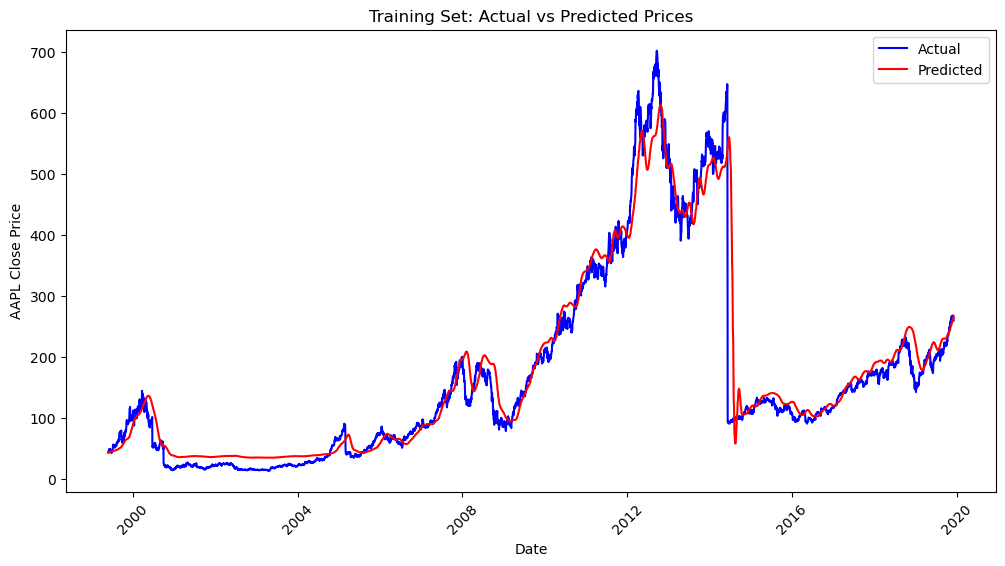

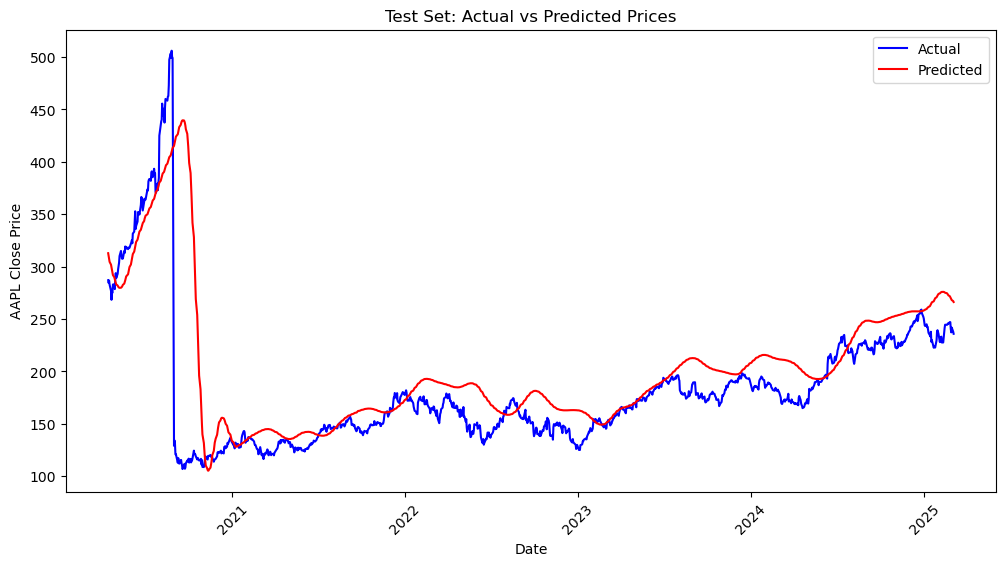

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


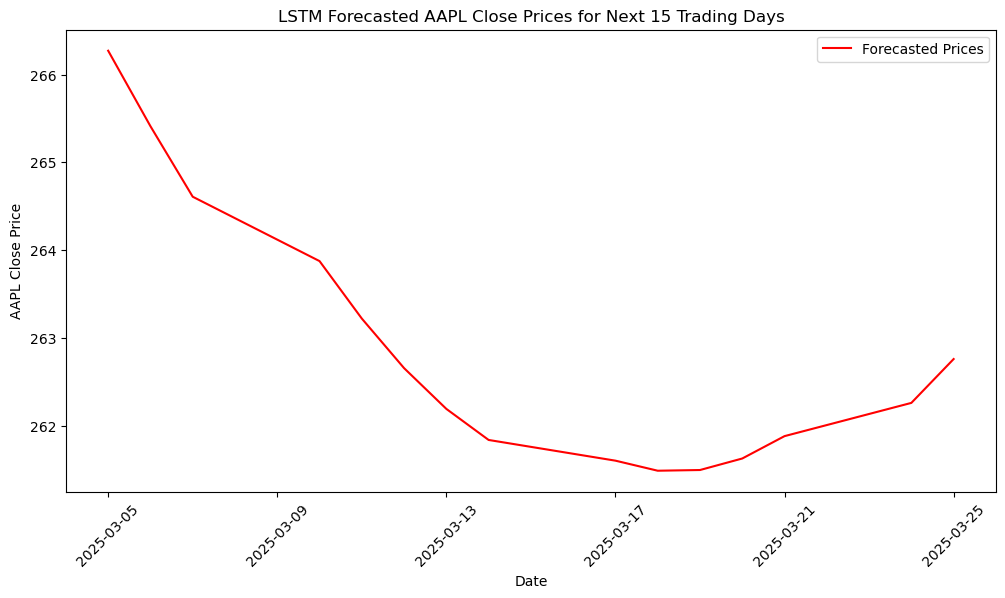

In [137]:
# Building LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(seq_length, 1), kernel_regularizer=l1_l2(0.01, 0.01)))
lstm_model.add(Dropout(0.3)) # Dropout of 30%
BatchNormalization(axis=1)
lstm_model.add(LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l1_l2(0.01, 0.01)))
lstm_model.add(Dropout(0.4)) # Dropout of 30%
BatchNormalization(axis=1)
lstm_model.add(LSTM(32, activation='tanh', return_sequences=False))
lstm_model.add(Dropout(0.3)) # Dropout of 30%
BatchNormalization(axis=1)
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1, activation='linear'))


lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
optimizer = AdamW(learning_rate=lr_schedule)

# compiling the model
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Training LSTM model
lstm_model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=1)

# Predictions on the test set
y_train_pred = lstm_model.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred)  # Inverse transform predictions
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))  # Inverse transform actual values


# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Training RMSE: {train_rmse}')


# Predictions on the test set
y_pred = lstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)  # Inverse transform predictions
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform actual values


# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {test_rmse}')

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data['date'].iloc[seq_length:], y=y_train.flatten(), label='Actual', color='blue')
sns.lineplot(x=train_data['date'].iloc[seq_length:], y=y_train_pred.flatten(), label='Predicted', color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Training Set: Actual vs Predicted Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data['date'].iloc[seq_length:], y=y_test.flatten(), label='Actual', color='blue')
sns.lineplot(x=test_data['date'].iloc[seq_length:], y=y_pred.flatten(), label='Predicted', color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Test Set: Actual vs Predicted Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Forecast the next 15 days
future_predictions = []
input_seq = X_test[-1].reshape(1, seq_length, 1)

for _ in range(15):
    pred = lstm_model.predict(input_seq)[0, 0]
    future_predictions.append(pred)
    new_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)
    input_seq = new_seq


# Convert forecasted values back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Create future dates
date_range = pd.date_range(start=pd.to_datetime(test_data['date'].max()) + pd.Timedelta(days=1), periods=15, freq='B')

# Plot forecasted prices
plt.figure(figsize=(12, 6))
sns.lineplot(x=date_range, y=future_predictions, label='Forecasted Prices', color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("LSTM Forecasted AAPL Close Prices for Next 15 Trading Days")
plt.legend()
plt.xticks(rotation=45)
plt.show()

    date_range  future_predictions    AAPL_close
0  2025-03-05       266.270721436 235.740000000
1  2025-03-06       265.411285400 235.330000000
2  2025-03-07       264.608825684 239.070000000
3  2025-03-10       263.876220703 227.480000000
4  2025-03-11       263.222198486 220.840000000
5  2025-03-12       262.657836914 216.980000000
6  2025-03-13       262.193878174 209.680000000
7  2025-03-14       261.840362549 213.490000000
8  2025-03-17       261.604675293 214.000000000
9  2025-03-18       261.490203857 212.690000000
10 2025-03-19       261.498260498 215.240000000
11 2025-03-20       261.629364014 214.100000000
12 2025-03-21       261.883941650 218.270000000
13 2025-03-24       262.262207031 220.730000000
14 2025-03-25       262.761474609 223.750000000
Pearson Correlation between forecasted prices and actual prices: 0.9160847052202308  with a p-value of: 1.6216232345354816e-06 
 Spearman Correlation between forecasted prices and actual prices: 0.8642857142857141  with a p-value o

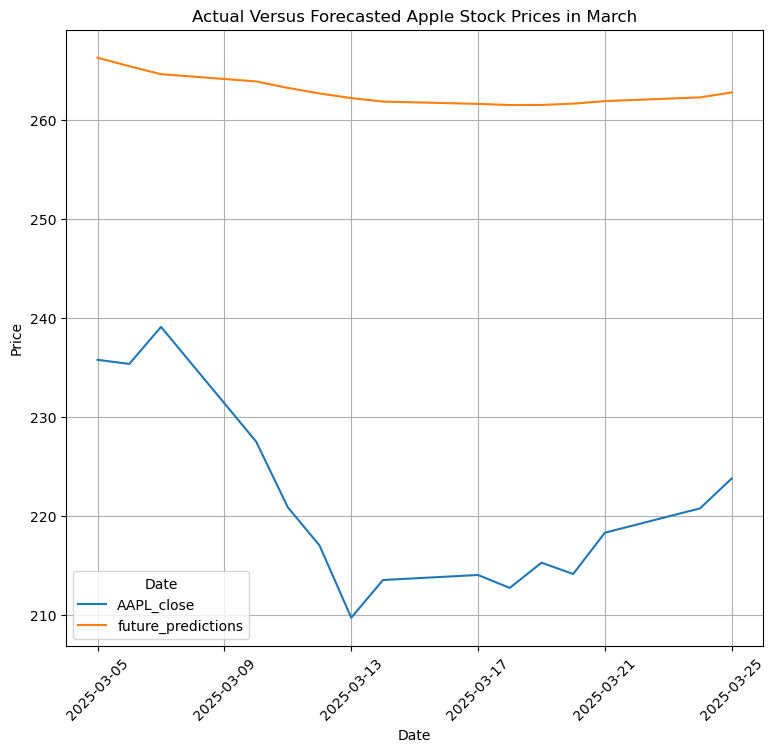

In [138]:
apple_lstm = pd.DataFrame({"date_range": date_range,
                         "future_predictions": future_predictions})

# apple_march_prices = pd.read_csv("march_prices/AAPL_march_prices.csv")


apple_lstm = pd.concat([apple_lstm, apple_march_prices['AAPL_close']], axis=1)
print(f" {apple_lstm}")


# Assuming you have two columns: 'future_predictions' and 'AAPL_close'
correlation, p_value = pearsonr(apple_lstm['future_predictions'], apple_lstm['AAPL_close'])

# Calculate Spearman's correlation
spearman_corr, p_value_spear = spearmanr(apple_lstm['future_predictions'], apple_lstm['AAPL_close'])


# Calculate Pearson correlation
correlation = apple_lstm[['future_predictions', 'AAPL_close']].corr().iloc[0, 1]


rmse = np.sqrt(np.mean((apple_lstm['AAPL_close'] - apple_lstm['future_predictions'])**2)) # for our given stock price ranges, rmse between 5-10 is good but the lower the better

mae = np.mean(np.abs((apple_lstm['AAPL_close'] - apple_lstm['future_predictions']))) # similarly for mae, the lower the better

mape = np.mean(np.abs((apple_lstm['AAPL_close'] - apple_lstm['future_predictions']) / apple_lstm['AAPL_close'])) * 100 # aim for mape below 10% if possible


# Prioritising correlation overall is key. Hopefully the ARIMA model beats this correlation and improves the other metrics as well

print(f"Pearson Correlation between forecasted prices and actual prices: {correlation}  with a p-value of: {p_value} \n",
      f"Spearman Correlation between forecasted prices and actual prices: {spearman_corr}  with a p-value of: {p_value_spear} \n", 
       
      f"Forecasted Root Mean Squared Error: {rmse} \n",
      f"Forecasted Mean Absolute Error: {mae} \n",
      f"Mean Absolute Percentage Error: {mape} \n")

# reshaping data for plotting in seaborn
apple_melted = apple_lstm.melt(id_vars=['date_range'],
                               value_vars=['AAPL_close', 'future_predictions'],
                               var_name='Date',
                               value_name='Price')

# Plotting in Seaborn
plt.figure(figsize=(9, 8))
sns.lineplot(data=apple_melted, x='date_range', y='Price', hue='Date', markers='o')

# labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Versus Forecasted Apple Stock Prices in March')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

# BI-LSTM Model for Apple

In [139]:
# Split data into train and test
split_date = np.quantile(s_appl['date_unix'], 0.8)
train_data = s_appl[s_appl['date_unix'] <= split_date]
test_data = s_appl[s_appl['date_unix'] > split_date]



# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 90  # Sequence length for LSTM

# Use the scaled 'MSFT_close_scaled' column for sequence creation
train_scaled = train_data[['AAPL_close_scaled']].values
test_scaled = test_data[['AAPL_close_scaled']].values

X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Epoch 1/10


c:\Users\ekf98\anaconda3\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


164/164 ━━━━━━━━━━━━━━━━━━━━ 47s 219ms/step - loss: 38.1364
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 221ms/step - loss: 1.3731
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 39s 239ms/step - loss: 0.5848
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 43s 265ms/step - loss: 0.3897
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 55s 334ms/step - loss: 0.2760
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 53s 323ms/step - loss: 0.1956
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 54s 330ms/step - loss: 0.1733
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 55s 334ms/step - loss: 0.1707
Epoch 9/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 57s 348ms/step - loss: 0.1541
Epoch 10/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 57s 348ms/step - loss: 0.1532
164/164 ━━━━━━━━━━━━━━━━━━━━ 30s 153ms/step
Training RMSE: 49.496908426706696
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step
Test RMSE: 65.45357224042912


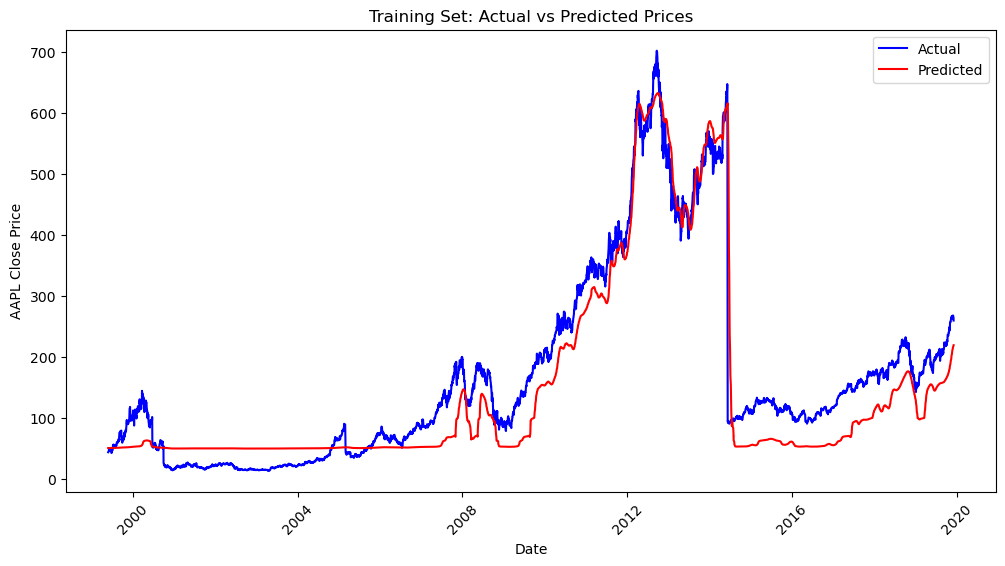

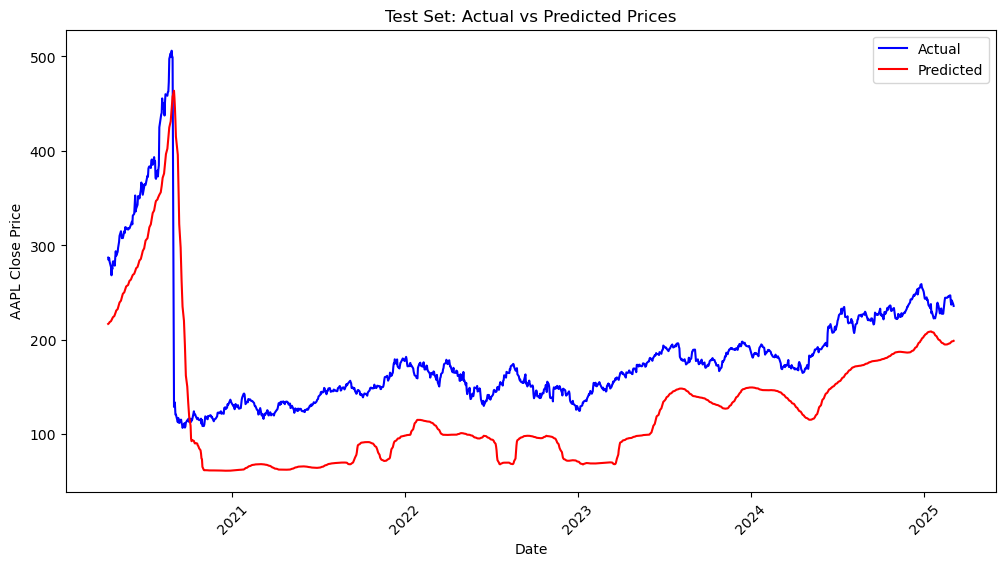

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


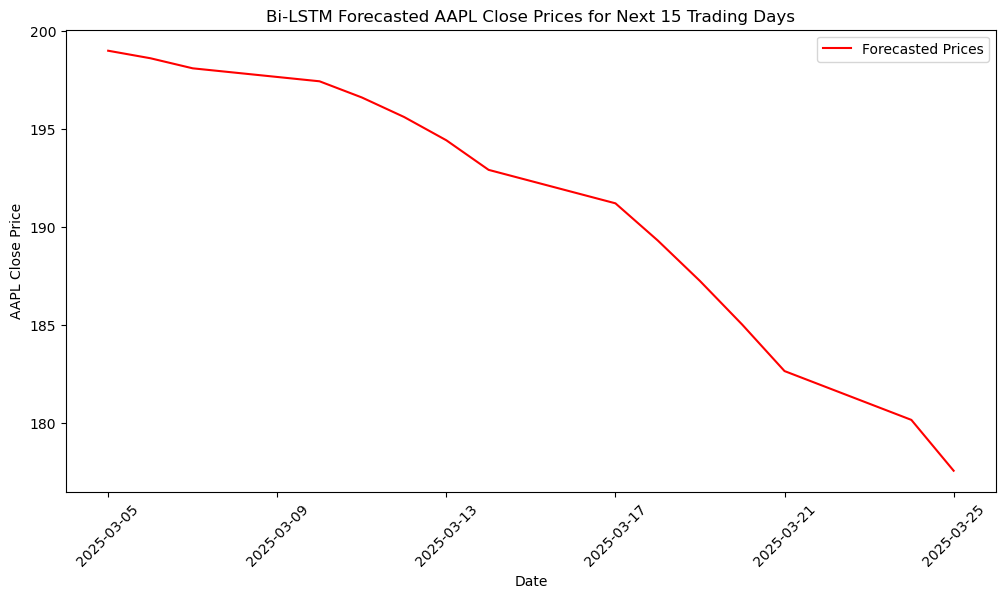

In [140]:
# Define Bidirectional LSTM Model
bilstm_model = Sequential([
    Bidirectional(LSTM(64, activation='tanh', kernel_regularizer=l1_l2(0.01, 0.01), return_sequences=True), input_shape=(seq_length, 1)),
    Dropout(0.3),
    BatchNormalization(),
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh', kernel_regularizer=l1_l2(0.01, 0.01))),
    Dropout(0.4),
    BatchNormalization(),
    Bidirectional(LSTM(32, activation='tanh', return_sequences=False)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])


lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
bilstm_optimizer = AdamW(learning_rate=lr_schedule)

# Compile the bi-lstm model
bilstm_model.compile(optimizer=bilstm_optimizer, loss='mean_squared_error')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predictions on the training set
y_train_pred = bilstm_model.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred)  # Inverse transform predictions
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))  # Inverse transform actual values


# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Training RMSE: {train_rmse}')


# Predictions on the test set
y_pred = bilstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)  # Inverse transform predictions
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform actual values

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse}')


# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data['date'].iloc[seq_length:], y=y_train.flatten(), label='Actual', color='blue')
sns.lineplot(x=train_data['date'].iloc[seq_length:], y=y_train_pred.flatten(), label='Predicted', color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Training Set: Actual vs Predicted Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data['date'].iloc[seq_length:], y=y_test.flatten(), label='Actual', color='blue')
sns.lineplot(x=test_data['date'].iloc[seq_length:], y=y_pred.flatten(), label='Predicted', color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Test Set: Actual vs Predicted Prices")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Forecast the next 15 days
future_predictions = []
input_seq = X_test[-1].reshape(1, seq_length, 1)

for _ in range(15):
    pred = bilstm_model.predict(input_seq)[0, 0]
    future_predictions.append(pred)
    new_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)
    input_seq = new_seq

# Convert forecasted values back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()
# Create future dates
date_range = pd.date_range(start=pd.to_datetime(test_data['date'].max()) + pd.Timedelta(days=1), periods=15, freq='B')

# Plot forecasted prices
plt.figure(figsize=(12, 6))
sns.lineplot(x=date_range, y=future_predictions, label='Forecasted Prices', color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Close Price")
plt.title("Bi-LSTM Forecasted AAPL Close Prices for Next 15 Trading Days")
plt.legend()
plt.xticks(rotation=45)
plt.show()

    date_range  future_predictions    AAPL_close
0  2025-03-05       198.971023560 235.740000000
1  2025-03-06       198.586486816 235.330000000
2  2025-03-07       198.072982788 239.070000000
3  2025-03-10       197.411148071 227.480000000
4  2025-03-11       196.586563110 220.840000000
5  2025-03-12       195.589508057 216.980000000
6  2025-03-13       194.400772095 209.680000000
7  2025-03-14       192.891510010 213.490000000
8  2025-03-17       191.184173584 214.000000000
9  2025-03-18       189.289260864 212.690000000
10 2025-03-19       187.220291138 215.240000000
11 2025-03-20       184.992996216 214.100000000
12 2025-03-21       182.624633789 218.270000000
13 2025-03-24       180.133819580 220.730000000
14 2025-03-25       177.539855957 223.750000000
Pearson Correlation between forecasted prices and actual prices: 0.42208166545596065  with a p-value of: 0.11707177813561784 
 Spearman Correlation between forecasted prices and actual prices: 0.4535714285714285  with a p-value of:

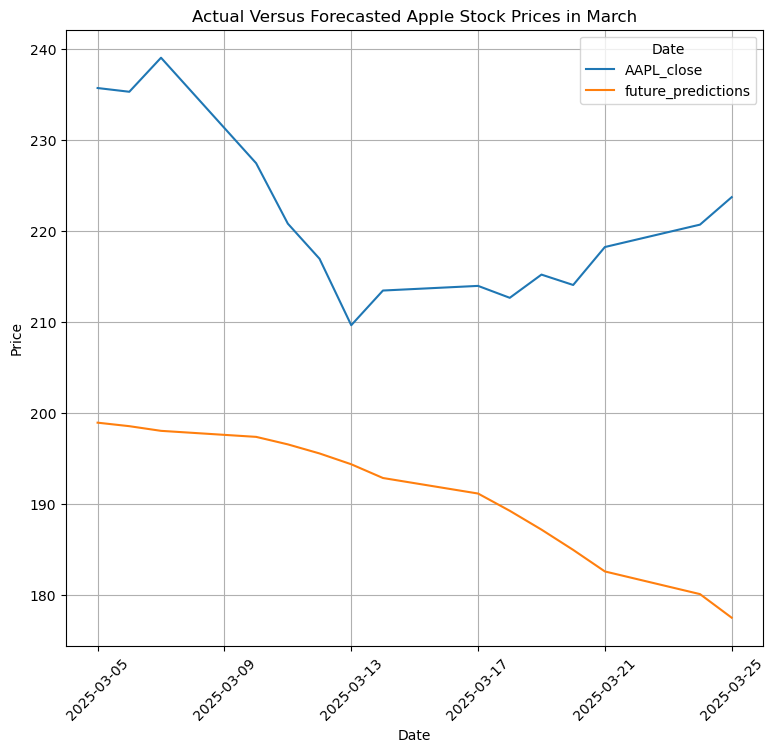

In [141]:
apple_Bilstm = pd.DataFrame({"date_range": date_range,
                         "future_predictions": future_predictions})

# apple_march_prices = pd.read_csv("march_prices/AAPL_march_prices.csv")


apple_Bilstm = pd.concat([apple_Bilstm, apple_march_prices['AAPL_close']], axis=1)
print(f" {apple_Bilstm}")


# Assuming you have two columns: 'future_predictions' and 'NVDA_close'
correlation, p_value = pearsonr(apple_Bilstm['future_predictions'], apple_Bilstm['AAPL_close'])

# Calculate Spearman's correlation
spearman_corr, p_value_spear = spearmanr(apple_Bilstm['future_predictions'], apple_Bilstm['AAPL_close'])


# Calculate Pearson correlation
correlation = apple_Bilstm[['future_predictions', 'AAPL_close']].corr().iloc[0, 1]


rmse = np.sqrt(np.mean((apple_Bilstm['AAPL_close'] - apple_Bilstm['future_predictions'])**2)) # for our given stock price ranges, rmse between 5-10 is good but the lower the better

mae = np.mean(np.abs((apple_Bilstm['AAPL_close'] - apple_Bilstm['future_predictions']))) # similarly for mae, the lower the better

mape = np.mean(np.abs((apple_Bilstm['AAPL_close'] - apple_Bilstm['future_predictions']) / apple_Bilstm['AAPL_close'])) * 100 # aim for mape below 10% if possible


# Prioritising correlation overall is key. Hopefully the ARIMA model beats this correlation and improves the other metrics as well

print(f"Pearson Correlation between forecasted prices and actual prices: {correlation}  with a p-value of: {p_value} \n",
      f"Spearman Correlation between forecasted prices and actual prices: {spearman_corr}  with a p-value of: {p_value_spear} \n", 
       
      f"Forecasted Root Mean Squared Error: {rmse} \n",
      f"Forecasted Mean Absolute Error: {mae} \n",
      f"Mean Absolute Percentage Error: {mape} \n")

# reshaping data for plotting in seaborn
apple_melted = apple_Bilstm.melt(id_vars=['date_range'],
                               value_vars=['AAPL_close', 'future_predictions'],
                               var_name='Date',
                               value_name='Price')

# Plotting in Seaborn
plt.figure(figsize=(9, 8))
sns.lineplot(data=apple_melted, x='date_range', y='Price', hue='Date', markers='o')

# labels
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Versus Forecasted Apple Stock Prices in March')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()